* `modeldate` represents the date when the poll model was run
* `startdate` | The first day interviews were conducted for this poll
* `enddate` | The last day interviews were conducted for this poll
* `pollster` | The name of the pollster
* `samplesize` | The size of the sample
* `population` | Whether the population interviewed was adults, registered voters, or likely voters
* `weight` | A relative weight that describes how much this poll factors into the forecast relative to other polls
* `influence` | A relative weight that describes how much this poll factors into today's the forecast (similar to "weight", but also takes into account how old the poll is)
* `pct` | Voteshare for this candidate in this poll
* `house_adjusted_pct` | Voteshare in this poll after applying the house adjustment
* `trend_and_house_adjusted_pct` | Voteshare in this poll after applying both house and trendline adjustments
* `tracking` | Whether or not the poll sample overlaps with other polls in our database
* `poll_id` | Unique identifier for a poll
* `question_id` | Unique identifier for a question

* `candidate_name`(Target) - Election Candidate

In [1]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import recall_score, precision_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (21, 9)

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
EXPERIMENT_NAME = "candidate-category-experiment"
mlflow.set_tracking_uri(f"sqlite:///mlflow.db")
TAGS={"Version": "v1", "priority": "P1",
      "Application":"Election Winner",
      "Developer": "Daniel",
      "Dataset": 'presidential_polls_2020.csv'}

client = MlflowClient()

try:
    experiment_id = client.create_experiment(
        name=EXPERIMENT_NAME,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
        tags=TAGS
    )
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
    mlflow.set_experiment(experiment_id=experiment_id)

print("Experiment ID: ",experiment_id)
print(mlflow.get_tracking_uri())

Experiment ID:  1
sqlite:///mlflow.db


Start MLFlow: mlflow ui --backend-store-uri sqlite:///mlflow.db

In [3]:
print(f"Tracking URI: '{mlflow.get_tracking_uri()}'")
print(f"Artifacts URI: '{mlflow.get_artifact_uri()}'")

Tracking URI: 'sqlite:///mlflow.db'
Artifacts URI: 'file:///Users/danny/Desktop/programming/DA/voltrox/mlruns/94b6741c33924b6f9db5a376e5838a5e/artifacts'


In [4]:
BASE_PATH = Path("__file__").parent.resolve()

In [5]:
raw_df = pd.read_csv(str(BASE_PATH / "presidential_polls_2020.csv"))

# 2. Exploratory Data Analysis and Pre-processing

In [6]:
print(raw_df.shape)
raw_df.info()
raw_df.head()

(6376, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6376 entries, 0 to 6375
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cycle                         6376 non-null   int64  
 1   state                         6376 non-null   object 
 2   modeldate                     6376 non-null   object 
 3   candidate_name                6376 non-null   object 
 4   startdate                     6376 non-null   object 
 5   enddate                       6376 non-null   object 
 6   pollster                      6376 non-null   object 
 7   samplesize                    6374 non-null   float64
 8   population                    6376 non-null   object 
 9   weight                        6376 non-null   float64
 10  influence                     6376 non-null   float64
 11  pct                           6376 non-null   float64
 12  house_adjusted_pct            6376 non-null   float

,cycle,state,modeldate,candidate_name,startdate,enddate,pollster,samplesize,population,weight,influence,pct,house_adjusted_pct,trend_and_house_adjusted_pct,tracking,poll_id,question_id
0,2020,Wyoming,10/27/2020,Joseph R. Biden Jr.,9/28/2020,10/25/2020,SurveyMonkey,654.0,lv,0.355849,0.355849,31.0,29.72329,29.76474,T,71978,134981
1,2020,Wyoming,10/27/2020,Joseph R. Biden Jr.,9/26/2020,10/24/2020,SurveyMonkey,649.0,lv,0.024280,0.024138,31.0,29.72329,29.77189,T,71893,134807
2,2020,Wyoming,10/27/2020,Joseph R. Biden Jr.,9/26/2020,10/23/2020,SurveyMonkey,638.0,lv,0.000000,0.000000,31.0,29.72329,29.78049,T,71826,134672
3,2020,Wyoming,10/27/2020,Joseph R. Biden Jr.,9/25/2020,10/22/2020,SurveyMonkey,616.0,lv,0.011784,0.011371,30.0,28.73825,28.84013,T,71765,134541
4,2020,Wyoming,10/27/2020,Joseph R. Biden Jr.,9/24/2020,10/21/2020,SurveyMonkey,605.0,lv,0.011547,0.011076,31.0,29.72329,29.83638,T,71682,134342


## Convert the features to the right format

In [7]:
# Convert the columns to their right format.
raw_df['modeldate'] = pd.to_datetime(raw_df.modeldate, format = '%m/%d/%Y')
raw_df['startdate'] = pd.to_datetime(raw_df.startdate, format = '%m/%d/%Y')
raw_df['enddate'] = pd.to_datetime(raw_df.enddate, format = '%m/%d/%Y')
raw_df.dtypes

cycle                                    int64
state                                   object
modeldate                       datetime64[ns]
candidate_name                          object
startdate                       datetime64[ns]
enddate                         datetime64[ns]
pollster                                object
samplesize                             float64
population                              object
weight                                 float64
influence                              float64
pct                                    float64
house_adjusted_pct                     float64
trend_and_house_adjusted_pct           float64
tracking                                object
poll_id                                  int64
question_id                              int64
dtype: object

# 2.2 Target Exploration (label)

In [8]:
raw_df.candidate_name.value_counts().sort_index()

candidate_name
Donald Trump           3188
Joseph R. Biden Jr.    3188
Name: count, dtype: int64

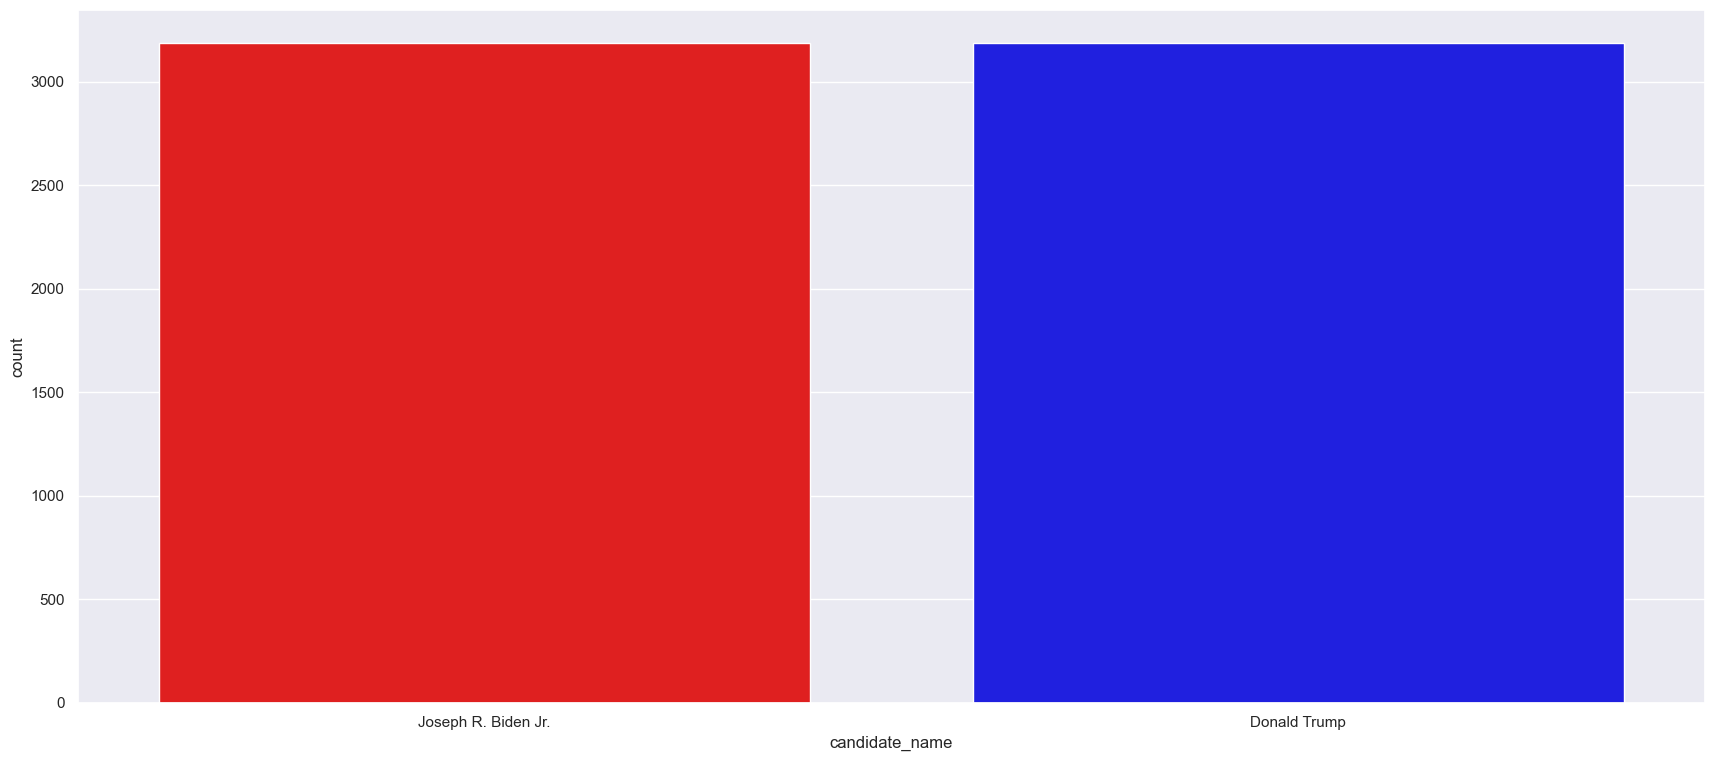

In [9]:
sns.countplot(x='candidate_name', data=raw_df, palette=["red", "blue"])
plt.show()

* Poll Inclusion: The plot shows that both Joseph R. Biden Jr. and Donald Trump are included in a very high number of polls, reflecting their significant relevance in the polling data.

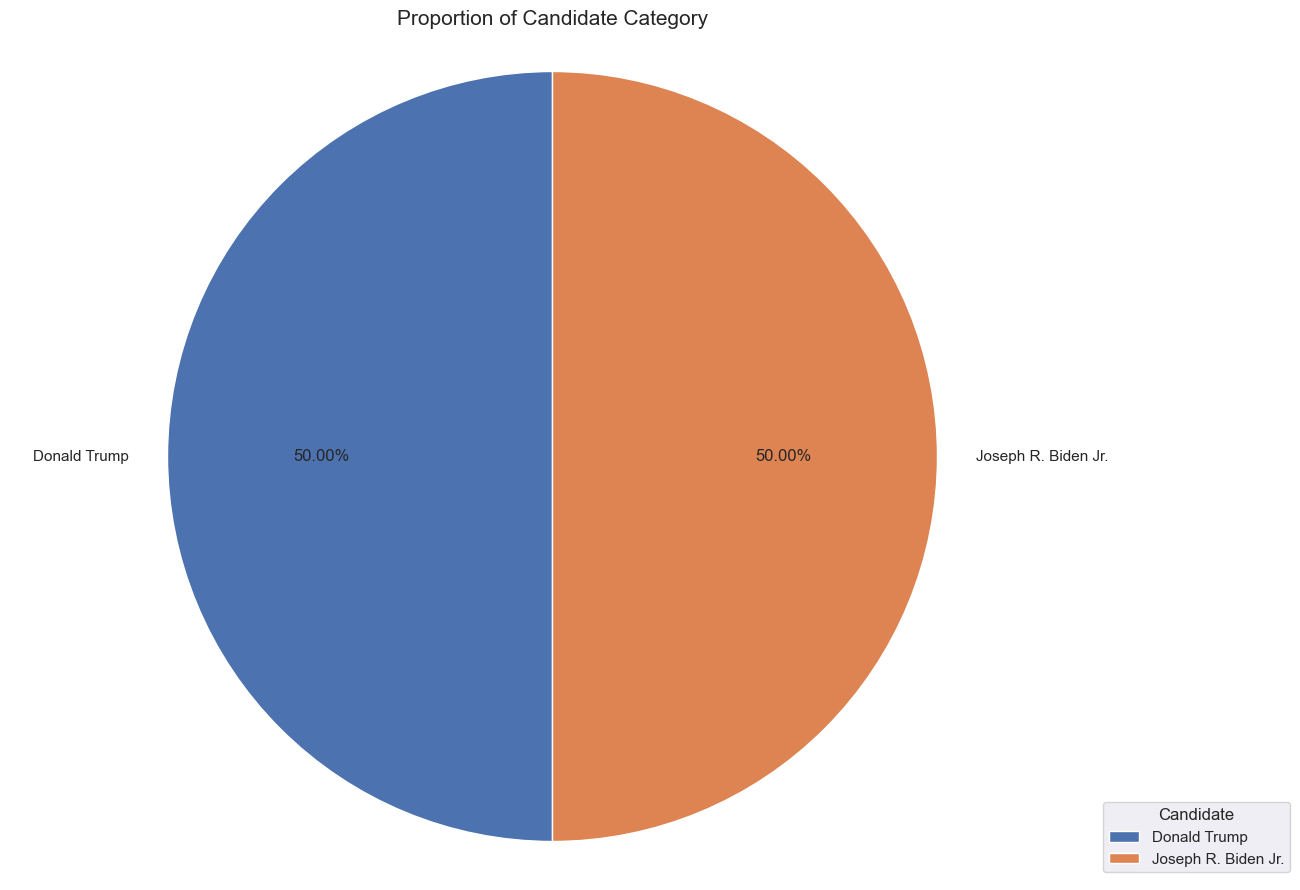

In [10]:
size = raw_df.candidate_name.value_counts().sort_index()
labels = 'Donald Trump', 'Joseph R. Biden Jr.'
fig, ax = plt.subplots(figsize = (14, 11))
ax.pie(size, explode = None, labels=labels, autopct='%2.2f%%', startangle=90)
ax.axis('equal')
plt.title('Proportion of Candidate Category', size=15)
ax.legend(labels, bbox_to_anchor = (1, 0), loc = 'lower left', title = 'Candidate')
plt.show()

The dataset is balanced as the categories (Donald Trump and Joseph R. Biden Jr.) are the same sample

# Check for Missing Values

In [11]:
raw_df.isnull().sum().sort_values(ascending=False)

tracking                        3534
samplesize                         2
cycle                              0
weight                             0
poll_id                            0
trend_and_house_adjusted_pct       0
house_adjusted_pct                 0
pct                                0
influence                          0
population                         0
state                              0
pollster                           0
enddate                            0
startdate                          0
candidate_name                     0
modeldate                          0
question_id                        0
dtype: int64

There are missing values in tracking and samplesize

I will replace the missing value of the sample size with the **mean** because it is a numeric column

In [12]:
raw_df["samplesize"] = raw_df.samplesize.fillna(raw_df.samplesize.mean())

In [13]:
raw_df.tracking.unique()

array(['T', nan], dtype=object)

In [14]:
raw_df.tracking.value_counts()

tracking
T    2842
Name: count, dtype: int64

Since the tracking signifies whether or not the poll sample overlaps with other polls, we will assume the missing values where poll that where not recorded(tracked). Therefore, i will replace the missing values with Not tracking instead.

In [15]:
raw_df['tracking'].fillna('Not Tracked', inplace=True)
# Replace 'T' with 'Tracking' in the 'tracking' column
raw_df['tracking'] = raw_df['tracking'].replace('T', 'Tracked')

In [16]:
raw_df['tracking'].value_counts()

tracking
Not Tracked    3534
Tracked        2842
Name: count, dtype: int64

In [17]:
raw_df.isnull().sum().sort_values(ascending=False)

cycle                           0
weight                          0
poll_id                         0
tracking                        0
trend_and_house_adjusted_pct    0
house_adjusted_pct              0
pct                             0
influence                       0
population                      0
state                           0
samplesize                      0
pollster                        0
enddate                         0
startdate                       0
candidate_name                  0
modeldate                       0
question_id                     0
dtype: int64

# Feature Analysis & Extraction

## Univariate Analysis

In [18]:
raw_df.nunique()

cycle                              1
state                             56
modeldate                          1
candidate_name                     2
startdate                        310
enddate                          305
pollster                         192
samplesize                      1790
population                         4
weight                          2825
influence                       1165
pct                              951
house_adjusted_pct              3769
trend_and_house_adjusted_pct    6361
tracking                           2
poll_id                         3188
question_id                     3188
dtype: int64

In [19]:
categorical_cols = raw_df.select_dtypes(include=['object']).columns
numerical_cols = raw_df.select_dtypes(include=['number']).columns

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: Index(['state', 'candidate_name', 'pollster', 'population', 'tracking'], dtype='object')
Numerical Columns: Index(['cycle', 'samplesize', 'weight', 'influence', 'pct',
       'house_adjusted_pct', 'trend_and_house_adjusted_pct', 'poll_id',
       'question_id'],
      dtype='object')


# Categorical Features

In [20]:
def plot_categorical_feature(df, col_name):
    plt.figure(figsize=(14, 8))
    sns.countplot(data=df, x=col_name, palette='viridis', order=df[col_name].value_counts().index)
    plt.title(f'Distribution of {col_name}', fontsize=16)
    plt.xlabel(col_name, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

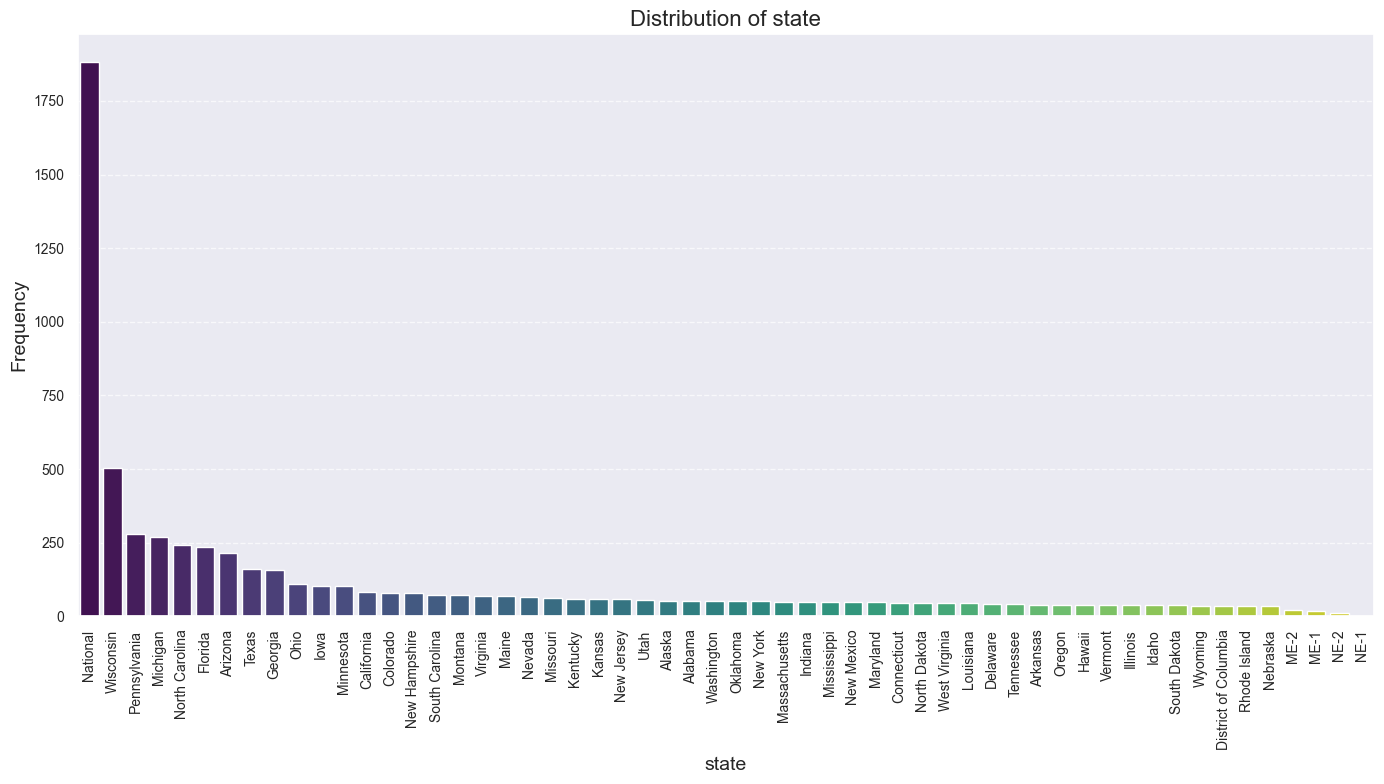

In [21]:
plot_categorical_feature(raw_df, 'state')

Observation: 

* National Polls: The high frequency of national polls suggests that there is significant interest in nationwide polling data, likely due to its broad relevance and impact. with over 1750 polls.

* Key States: States like Wisconsin, Pennsylvania, Michigan, and Florida have a high number of polls. These states are often considered battleground states in elections, which explains the higher polling activity.

* Less Polled States: Many states have relatively few polls, which might be due to their lesser impact on the overall election outcomes or lower population sizes.

In [22]:
raw_df.pollster.value_counts()

pollster
SurveyMonkey                                                     2116
Morning Consult                                                   880
YouGov                                                            246
Change Research                                                   178
Ipsos                                                             152
Public Policy Polling                                             142
Redfield & Wilton Strategies                                      138
USC Dornsife/Los Angeles Times                                    130
Data for Progress                                                  94
Civiqs                                                             88
Quinnipiac University                                              88
RMG Research                                                       80
Fox News/Beacon Research/Shaw & Co. Research                       78
Siena College/The New York Times Upshot                            78
Rasmussen R

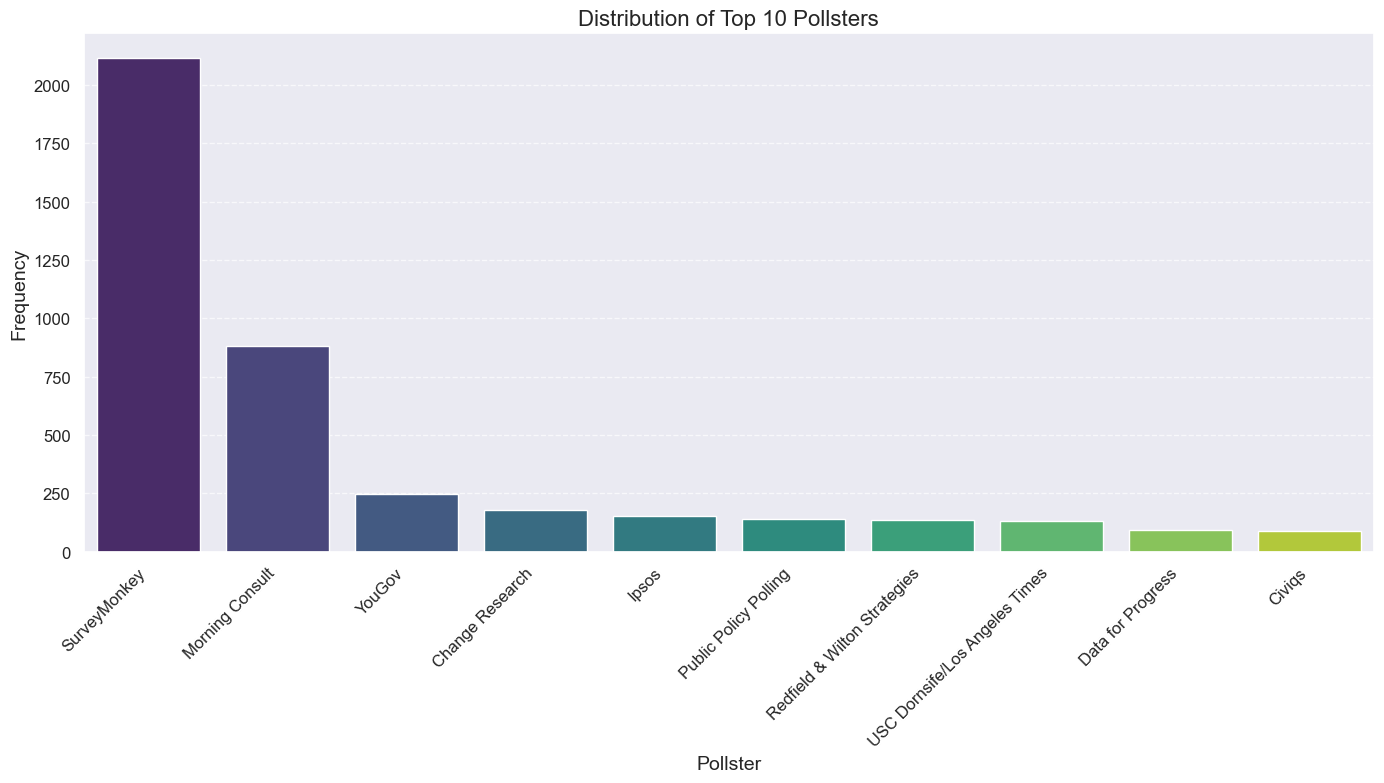

In [23]:
# Get the top 10 pollsters
top_10_pollsters = raw_df['pollster'].value_counts().head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_10_pollsters.index, y=top_10_pollsters.values, palette='viridis')
plt.title('Distribution of Top 10 Pollsters', fontsize=16)
plt.xlabel('Pollster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observation:
* SurveyMonkey has the highest number of polls at 2116, followed by Morning Consult with 880 polls. The other pollsters in the list have fewer polls than these two.

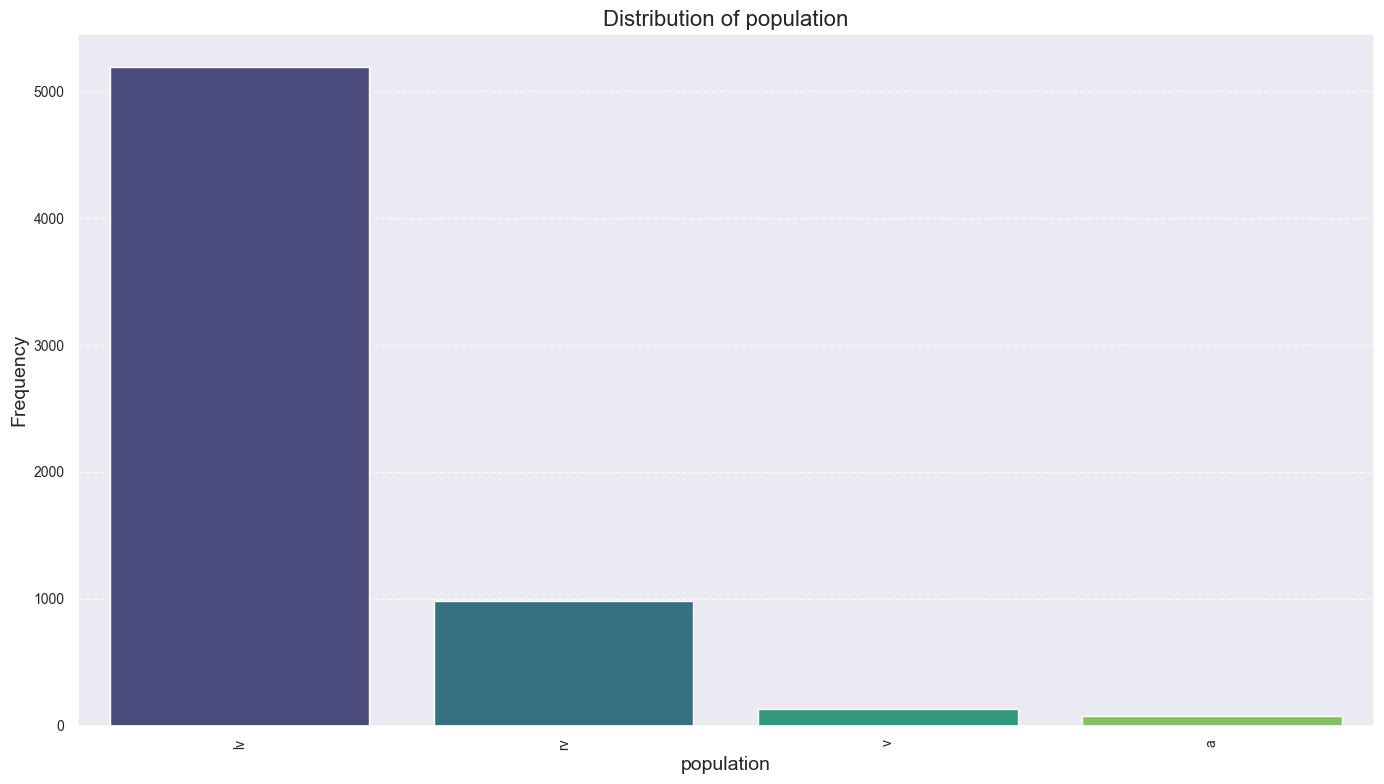

In [24]:
plot_categorical_feature(raw_df, 'population')

Observation:

* Likely Voters (lv) are the most common category of people who turn out to vote in the election, followed by Registered Voters (rv). The voters (v) and adults (a) categories are the least common.

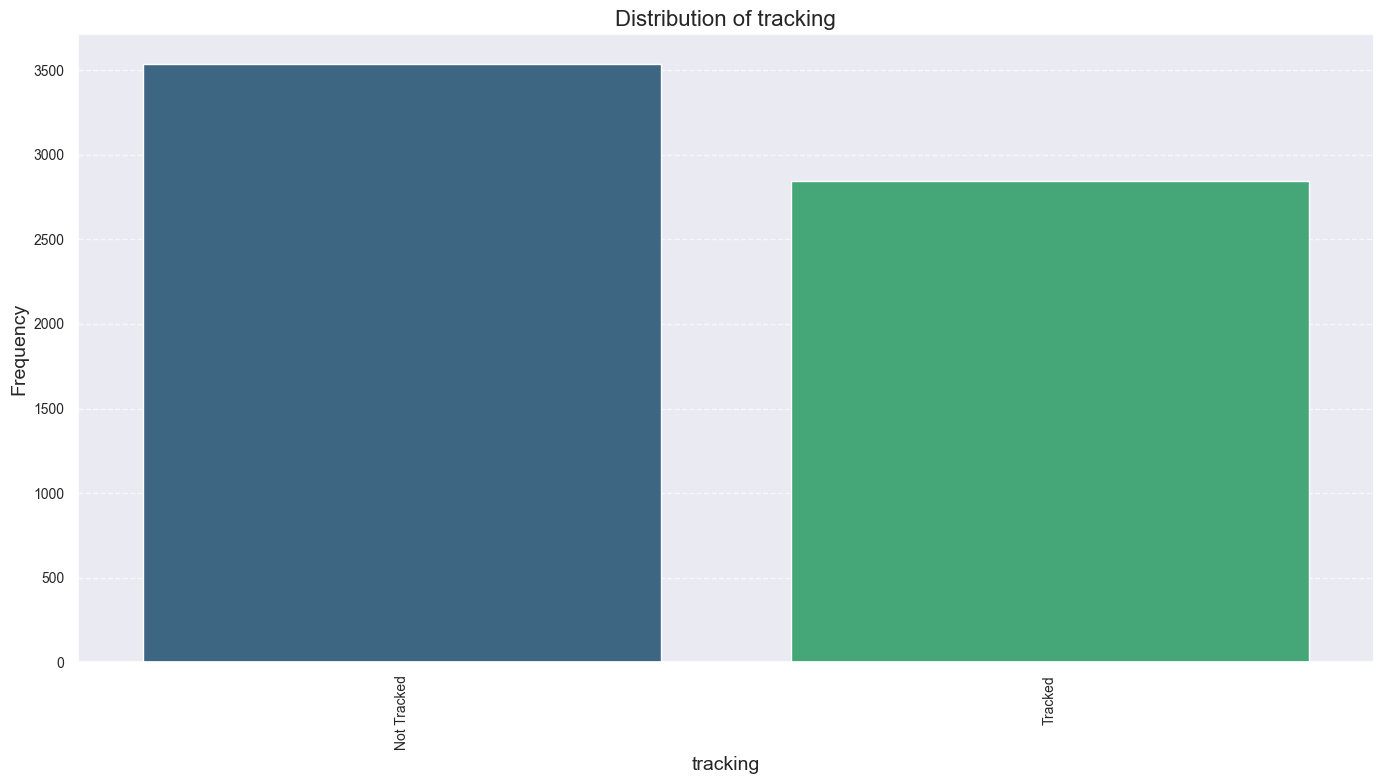

In [25]:
plot_categorical_feature(raw_df, 'tracking')

Observation:
* Most of the polls were not tracked

# Numerical Features

## Descriptive statistics

In [26]:
# Perform descriptive statistics on numerical columns except cycle, and question_id
numeric_cols = raw_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop(['question_id', 'cycle', 'poll_id'])

raw_df[numeric_cols].describe()

,samplesize,weight,influence,pct,house_adjusted_pct,trend_and_house_adjusted_pct
count,6376.000000,6376.000000,6376.000000,6376.000000,6376.000000,6376.000000
mean,3439.506432,0.568433,0.065914,47.111873,46.653722,47.306821
std,5145.835677,0.537149,0.195303,7.510800,7.260506,7.387173
min,88.000000,0.000000,0.000000,8.000000,6.624857,6.939298
25%,792.500000,0.067827,0.000000,43.000000,42.484088,42.873535
50%,1098.000000,0.552710,0.000000,47.000000,46.633775,47.272855
75%,3649.500000,0.884412,0.012761,51.000000,50.544690,51.637570
max,34460.000000,4.441382,1.940268,90.530000,89.743520,90.235790


Looking at the difference between max and mean across the each column above, there is seem to be outliers present in the samplesize, weight, house_adjusted_pct, trend_and_house_adjusted_pct. We will go deeper with IQR.

## Outlier Detection and Treatment

IQR (Inter Quantile Range) for Outlier Detection

In [27]:
def detect_outliers(df, numeric_cols, q1Per=0.03, q3Per=0.97, remove_outlier=True):
    """
    Function to detect or remove outliers in specified columns.

    Args:
        df (pd.DataFrame): DataFrame of the data.
        numeric_cols (list): List of column names to check for outliers.
        remove_outlier (bool): If True, remove outliers; if False, return outliers.

    Returns:
        pd.DataFrame: DataFrame with outliers removed or DataFrame of detected outliers.
    """
    for col in numeric_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is not in the DataFrame")
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' is not numeric")

    Q1 = df[numeric_cols].quantile(q1Per)
    Q3 = df[numeric_cols].quantile(q3Per)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    if remove_outlier:
        filtered_df = df[~((df[numeric_cols] < lower_limit) | (df[numeric_cols] > upper_limit)).any(axis=1)]
        print('Shape after outlier removal ->', filtered_df.shape)
        return filtered_df
    else:
        outliers_df = df[((df[numeric_cols] < lower_limit) | (df[numeric_cols] > upper_limit)).any(axis=1)]
        print('Shape before outlier removal ->', df.shape)
        print('Shape of detected outliers ->', outliers_df.shape)
        return outliers_df


In [28]:
def outlierCheck(dataframe: pd.DataFrame, col_name: str):
    plt.figure(figsize = (13, 5))
    sns.boxplot(dataframe[col_name])
    plt.show()

def outlierPDFCheck(dataframe: pd.DataFrame, col_name: str, color="green"):
    plt.figure(figsize = (13, 5))
    sns.distplot(dataframe[col_name], color=color)
    plt.show()

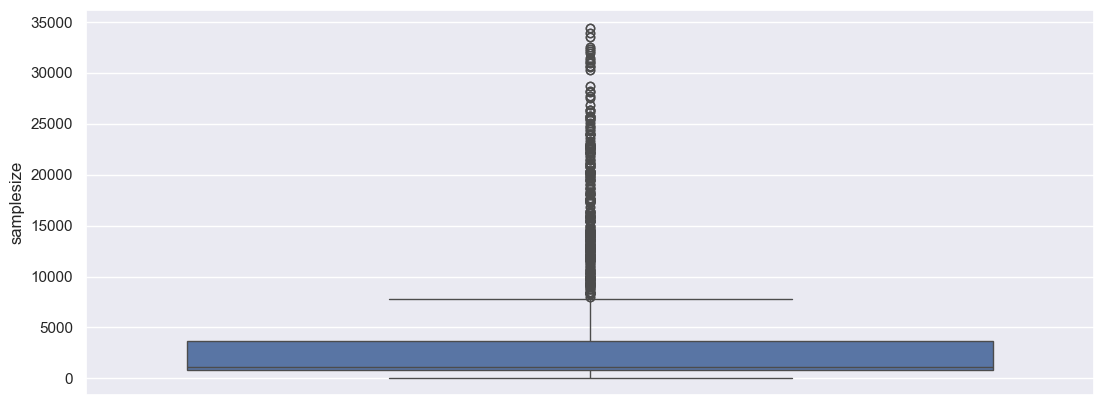

In [29]:
outlierCheck(raw_df, "samplesize")

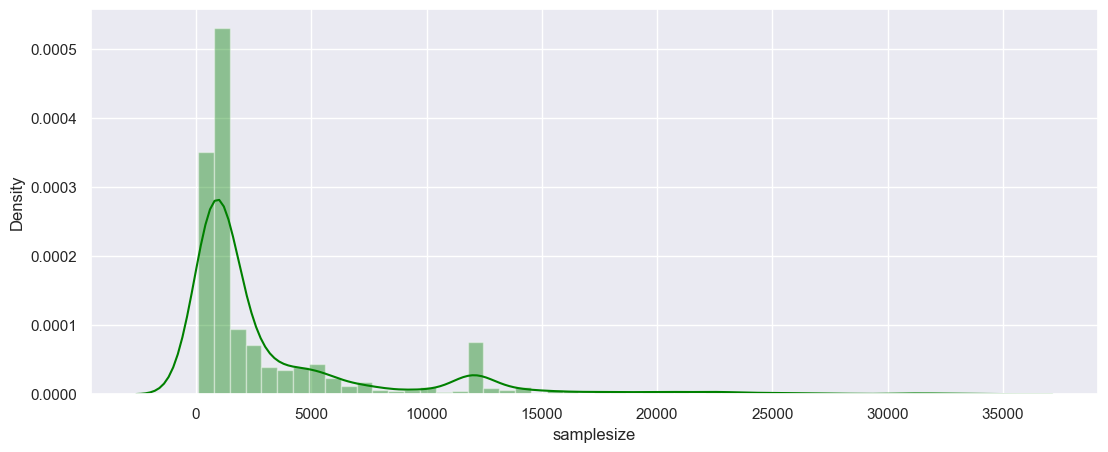

In [30]:
outlierPDFCheck(raw_df, "samplesize")

The **samplesize** distribution is right-skewed (positively skewed)

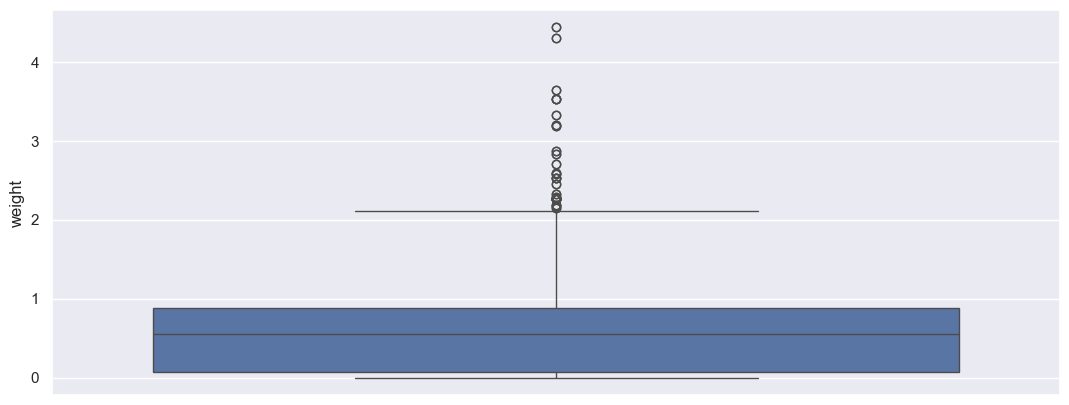

In [31]:
outlierCheck(raw_df, "weight")

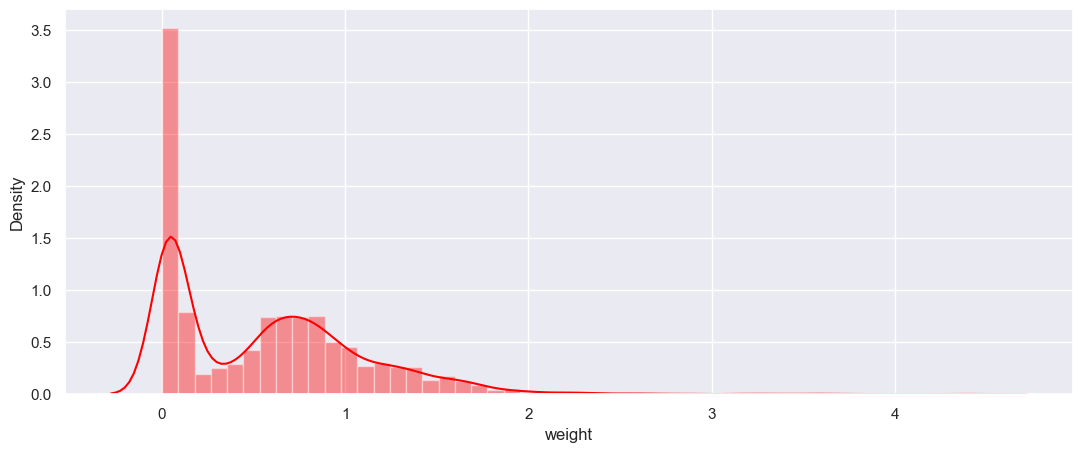

In [32]:
outlierPDFCheck(raw_df, "weight", 'red')

The **weight** distribution is right-skewed

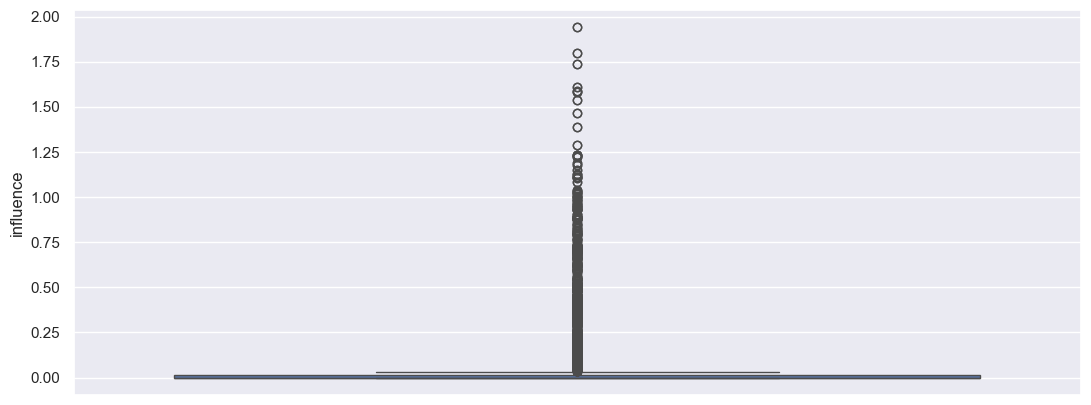

In [33]:
outlierCheck(raw_df, "influence")

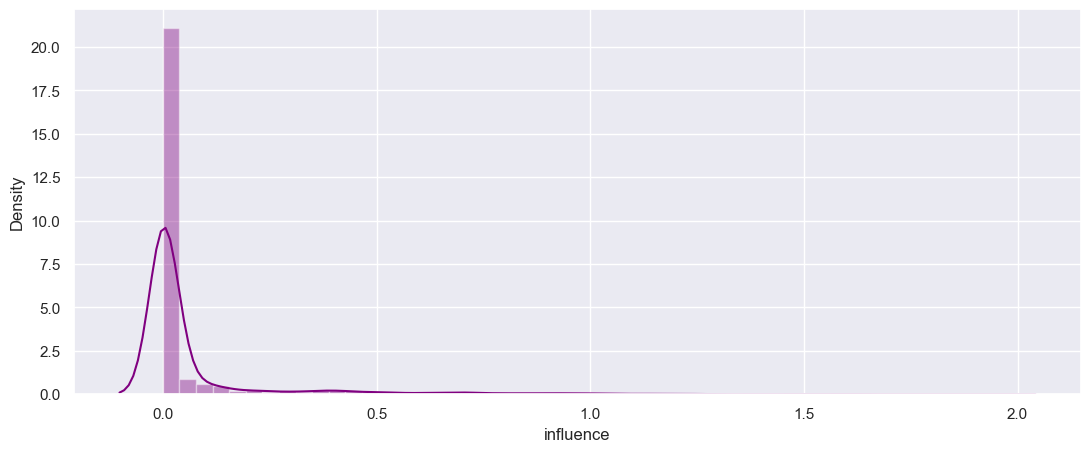

In [34]:
outlierPDFCheck(raw_df, "influence", 'purple')

The **influence** distribution is heavily skewed to the right

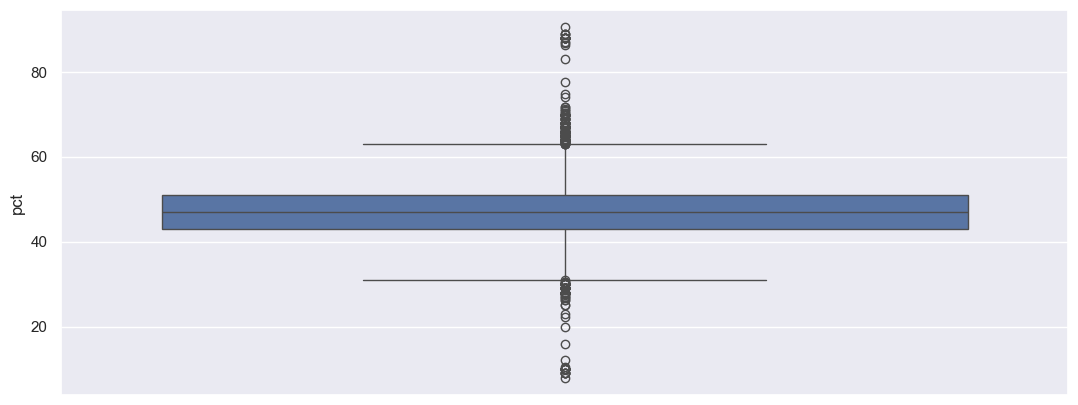

In [35]:
outlierCheck(raw_df, "pct")

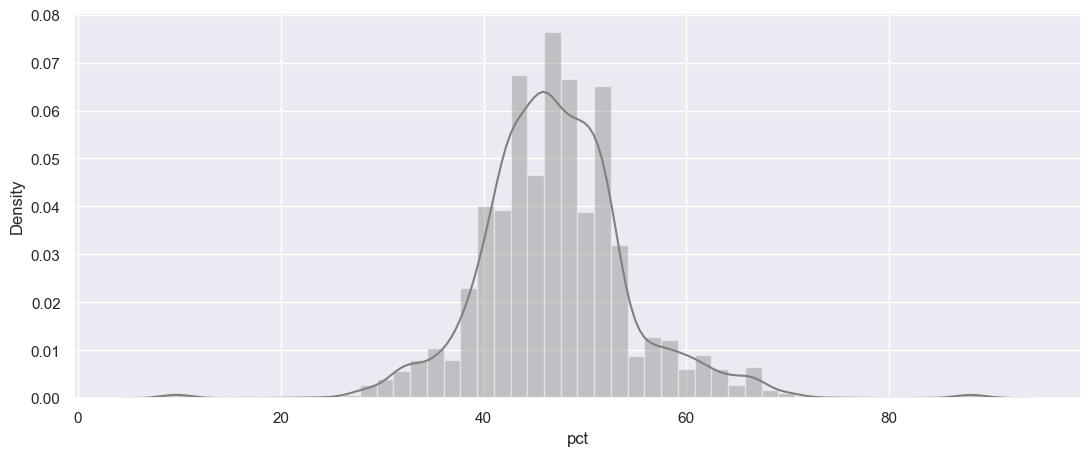

In [36]:
outlierPDFCheck(raw_df, "pct", 'gray')

The pct follows a Guassian distribution. which is perfect.

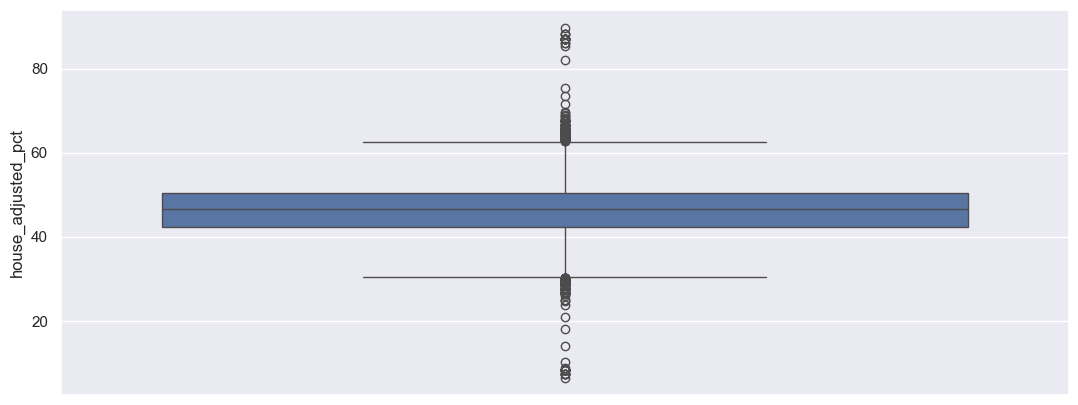

In [37]:
outlierCheck(raw_df, "house_adjusted_pct")

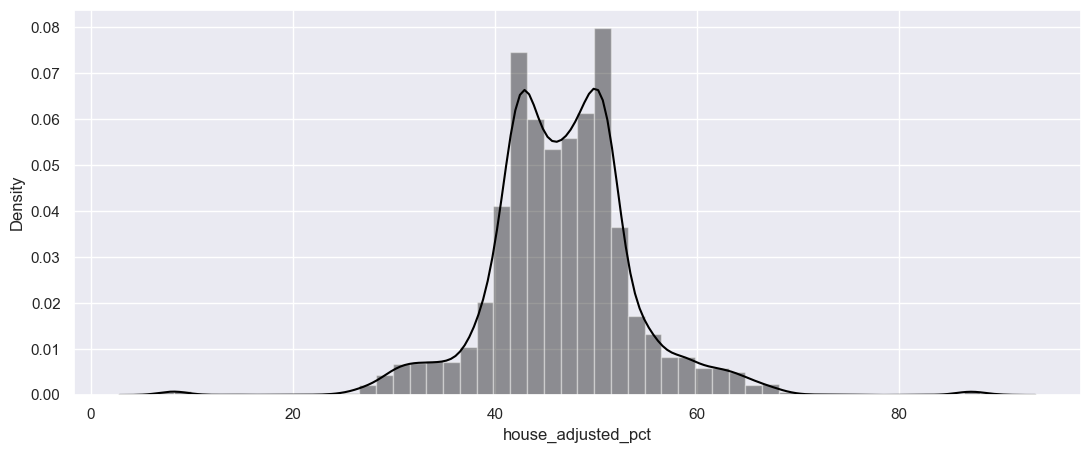

In [38]:
outlierPDFCheck(raw_df, "house_adjusted_pct", 'black')

The **house_adjusted_pct** is normal distribution.

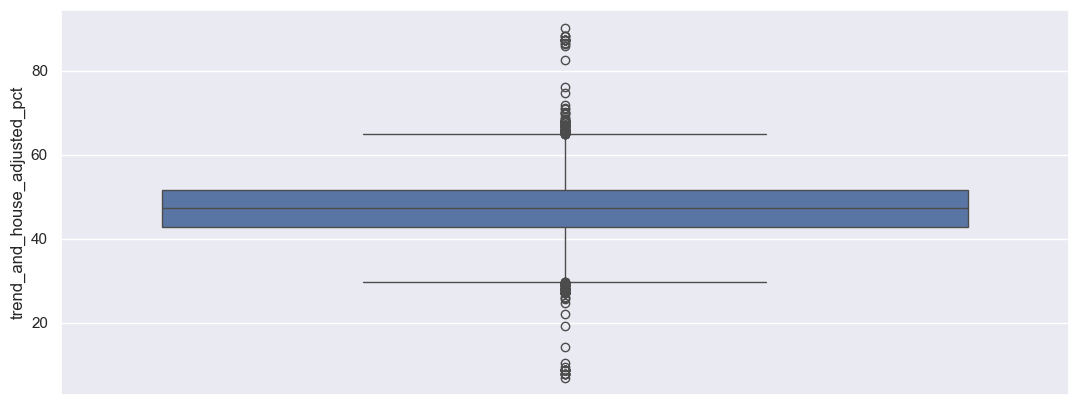

In [39]:
outlierCheck(raw_df, "trend_and_house_adjusted_pct")

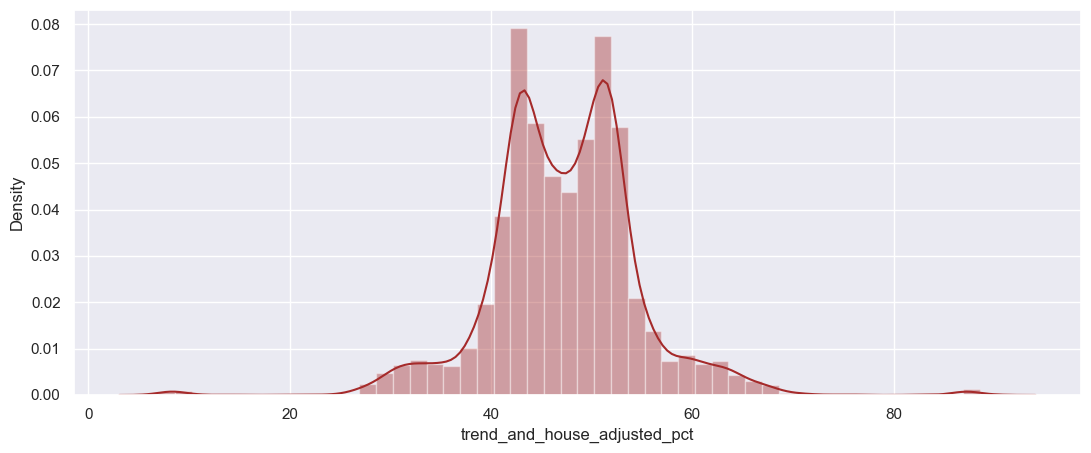

In [40]:
outlierPDFCheck(raw_df, "trend_and_house_adjusted_pct", 'brown')

The **trend_and_house_adjusted_pct** is normal distribution.

# Treat Outliers

In [41]:
raw_df_copy = raw_df.copy()

detect_outliers(raw_df_copy, ['samplesize', 'weight', 'influence'], remove_outlier=False)

Shape before outlier removal -> (6376, 17)
Shape of detected outliers -> (10, 17)


,cycle,state,modeldate,candidate_name,startdate,enddate,pollster,samplesize,population,weight,influence,pct,house_adjusted_pct,trend_and_house_adjusted_pct,tracking,poll_id,question_id
323,2020,Virginia,2020-10-27,Joseph R. Biden Jr.,2020-10-13,2020-10-19,ABC News/The Washington Post,908.0,lv,1.940268,1.940268,52.0,51.88296,51.90357,Not Tracked,71659,134245
739,2020,Oklahoma,2020-10-27,Joseph R. Biden Jr.,2020-10-15,2020-10-20,SoonerPoll.com,5466.0,lv,1.796209,1.796209,36.5,36.43803,36.56331,Not Tracked,71629,134192
767,2020,Ohio,2020-10-27,Joseph R. Biden Jr.,2020-10-17,2020-10-20,Fox News/Beacon Research/Shaw & Co. Research,1018.0,lv,1.739048,1.739048,45.0,44.97205,44.98877,Not Tracked,71626,134184
2052,2020,National,2020-10-27,Joseph R. Biden Jr.,2020-01-14,2020-01-16,SurveyUSA,4069.0,rv,4.441382,0.000000,50.0,49.91235,52.14692,Not Tracked,63295,115912
2065,2020,National,2020-10-27,Joseph R. Biden Jr.,2019-11-20,2019-11-21,SurveyUSA,3850.0,rv,4.307248,0.000000,52.0,51.91243,53.85331,Not Tracked,62979,114009
3511,2020,Virginia,2020-10-27,Donald Trump,2020-10-13,2020-10-19,ABC News/The Washington Post,908.0,lv,1.940268,1.940268,41.0,40.91833,41.21007,Not Tracked,71659,134245
3927,2020,Oklahoma,2020-10-27,Donald Trump,2020-10-15,2020-10-20,SoonerPoll.com,5466.0,lv,1.796209,1.796209,58.5,58.48758,58.59932,Not Tracked,71629,134192
3955,2020,Ohio,2020-10-27,Donald Trump,2020-10-17,2020-10-20,Fox News/Beacon Research/Shaw & Co. Research,1018.0,lv,1.739048,1.739048,48.0,48.50339,48.64447,Not Tracked,71626,134184
5240,2020,National,2020-10-27,Donald Trump,2020-01-14,2020-01-16,SurveyUSA,4069.0,rv,4.441382,0.000000,43.0,44.41911,42.49010,Not Tracked,63295,115912
5253,2020,National,2020-10-27,Donald Trump,2019-11-20,2019-11-21,SurveyUSA,3850.0,rv,4.307248,0.000000,39.0,40.39467,39.53397,Not Tracked,62979,114009


In [42]:
df_no_outlier = detect_outliers(raw_df_copy, ['samplesize', 'weight', 'influence'])

Shape after outlier removal -> (6366, 17)


Outliers has been removed from the data. Let's confirm fron using graphical representation of those columns 'samplesize', 'weight', 'influence'.

In [43]:
def visualize_numerical_cols(df, numeric_cols, color='blue'):
    """
    Function to create boxplot and distribution plot for each numerical column.

    Args:
        df (pd.DataFrame): DataFrame of the data.
        numeric_cols (list): List of column names to visualize.
        color (str): Color for the plots.

    Returns:
        None
    """
    for col in numeric_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is not in the DataFrame")
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' is not numeric")

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

        # Boxplot
        sns.boxplot(x=df[col], ax=ax1)
        ax1.set_title(f'Boxplot of {col}')

        # Distribution plot
        sns.distplot(df[col], color=color, ax=ax2)
        ax2.set_title(f'Distribution plot of {col}')

        plt.show()


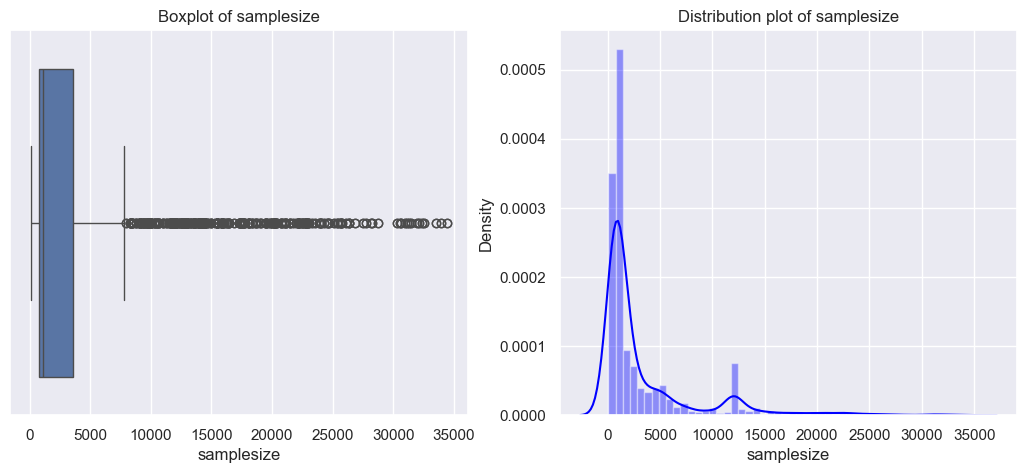

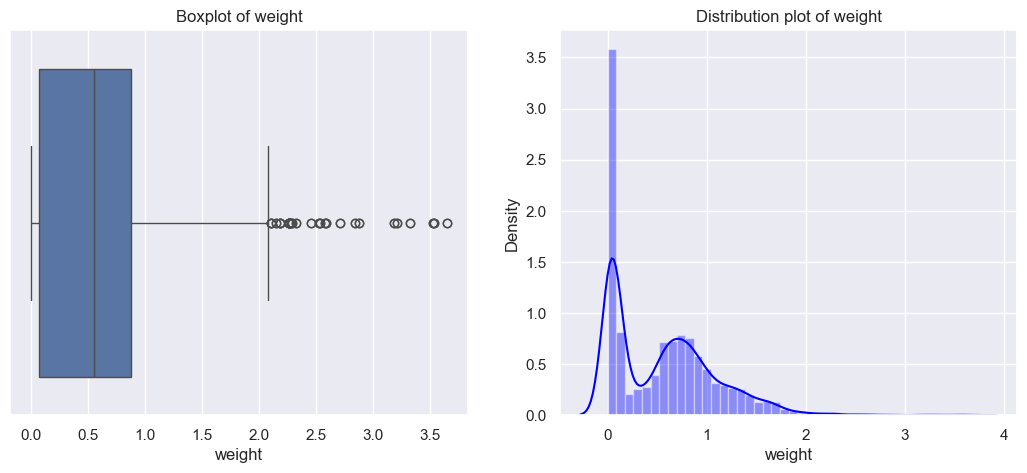

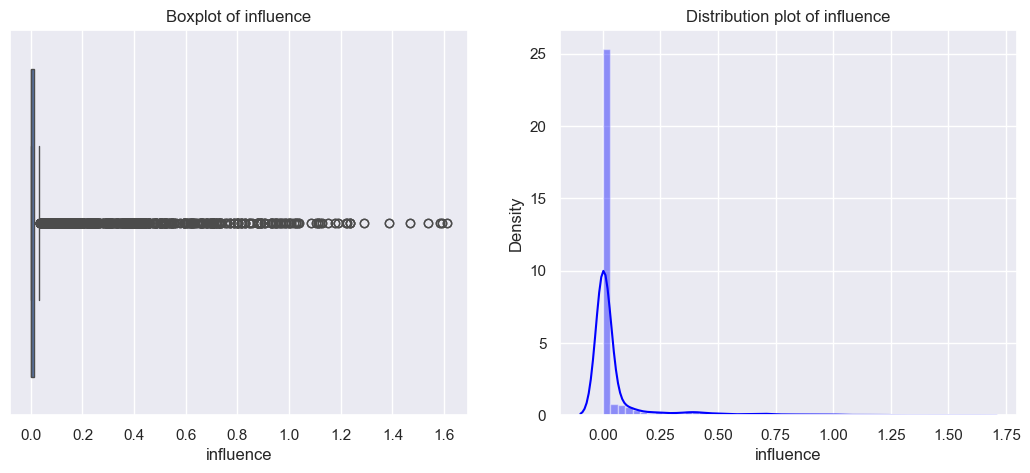

In [44]:
visualize_numerical_cols(df_no_outlier, ['samplesize', 'weight', 'influence'])

In [45]:
print(df_no_outlier.shape)
df_no_outlier.head()

(6366, 17)


,cycle,state,modeldate,candidate_name,startdate,enddate,pollster,samplesize,population,weight,influence,pct,house_adjusted_pct,trend_and_house_adjusted_pct,tracking,poll_id,question_id
0,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-28,2020-10-25,SurveyMonkey,654.0,lv,0.355849,0.355849,31.0,29.72329,29.76474,Tracked,71978,134981
1,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-26,2020-10-24,SurveyMonkey,649.0,lv,0.024280,0.024138,31.0,29.72329,29.77189,Tracked,71893,134807
2,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-26,2020-10-23,SurveyMonkey,638.0,lv,0.000000,0.000000,31.0,29.72329,29.78049,Tracked,71826,134672
3,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-25,2020-10-22,SurveyMonkey,616.0,lv,0.011784,0.011371,30.0,28.73825,28.84013,Tracked,71765,134541
4,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-24,2020-10-21,SurveyMonkey,605.0,lv,0.011547,0.011076,31.0,29.72329,29.83638,Tracked,71682,134342


# Date Feature

In [46]:
df_no_outlier.startdate.min(), df_no_outlier.startdate.max()

(Timestamp('2019-11-03 00:00:00'), Timestamp('2020-10-26 00:00:00'))

Observation:

* Indicates that the earliest date in the startdate is November 3, 2019, and the latest date is October 26, 2020 of the Election.

In [47]:
df_no_outlier.enddate.min(), df_no_outlier.enddate.max()

(Timestamp('2019-11-05 00:00:00'), Timestamp('2020-10-26 00:00:00'))

Observation:

* Similarly, the earliest date in the enddate column is November 5, 2019, and the latest date is October 26, 2020 of the Election.

Clearly, the Election took almost a year from November 2019 to October 2020. To look at trends, we first need to extract week days, minutes, and hours of day and timezones from the startdate and enddate dates.

In [48]:
def get_time_of_day(hour):
    """
    Function to calculate 4 timezones:

    'Morning' (6:00 am - 11:59 am (00:00))
    'Afternoon' (12:00 pm - 3:59 pm)
    'Evening' (4:00 pm - 9:59 pm)
    'Late Night' (10:00 pm - 5:59 am)
    """
    if 6 <= hour < 0:
        return "Morning"
    elif 0 <= hour < 16:
        return "Afternoon"
    elif 16 <= hour < 22:
        return "Evening"
    else:
        return "Late_Night"


In [49]:
df_no_outlier_copy = df_no_outlier.copy()

In [50]:
df_no_outlier_copy.loc[:, 'poll_duration'] = (df_no_outlier_copy['enddate'] - df_no_outlier_copy['startdate']).dt.days
df_no_outlier_copy['poll_start_year'] = df_no_outlier_copy['startdate'].dt.year
df_no_outlier_copy['poll_start_month'] = df_no_outlier_copy['startdate'].dt.month
df_no_outlier_copy['poll_start_day'] = df_no_outlier_copy['startdate'].dt.day
df_no_outlier_copy['poll_start_weekday'] = df_no_outlier_copy['startdate'].apply(lambda x: x.day_name())
df_no_outlier_copy['pollster_influence_weighted'] = df_no_outlier_copy['weight'] * df_no_outlier_copy['influence']
df_no_outlier_copy['poll_start_weekofyear'] = df_no_outlier_copy['startdate'].dt.isocalendar().week
# Day of Week (Numeric, Monday=0, Sunday=6)
df_no_outlier_copy['poll_start_dayofweek'] = df_no_outlier_copy['startdate'].dt.dayofweek
df_no_outlier_copy['poll_start_minute'] = df_no_outlier_copy['startdate'].dt.minute
df_no_outlier_copy['poll_start_hour'] = df_no_outlier_copy['startdate'].dt.hour
df_no_outlier_copy['time_of_day'] = df_no_outlier_copy['poll_start_hour'].apply(get_time_of_day)

df_no_outlier_copy['poll_end_year'] = df_no_outlier_copy['enddate'].dt.year
df_no_outlier_copy['poll_end_month'] = df_no_outlier_copy['enddate'].dt.month
df_no_outlier_copy['poll_end_day'] = df_no_outlier_copy['enddate'].dt.day
df_no_outlier_copy['poll_end_weekday'] = df_no_outlier_copy['enddate'].apply(lambda x: x.day_name())
df_no_outlier_copy['pollster_influence_weighted'] = df_no_outlier_copy['weight'] * df_no_outlier_copy['influence']
df_no_outlier_copy['poll_end_weekofyear'] = df_no_outlier_copy['enddate'].dt.isocalendar().week
df_no_outlier_copy['poll_end_dayofweek'] = df_no_outlier_copy['enddate'].dt.dayofweek
df_no_outlier_copy['poll_end_minute'] = df_no_outlier_copy['enddate'].dt.minute
df_no_outlier_copy['poll_end_hour'] = df_no_outlier_copy['enddate'].dt.hour
df_no_outlier_copy['end_time_of_day'] = df_no_outlier_copy['poll_end_hour'].apply(get_time_of_day)

df_no_outlier_copy['model_month'] = df_no_outlier_copy['modeldate'].dt.month
df_no_outlier_copy['model_quarter'] = df_no_outlier_copy['modeldate'].dt.quarter
df_no_outlier_copy['model_dayofweek'] = df_no_outlier_copy['modeldate'].dt.dayofweek

df_no_outlier_copy['model_to_start_days'] = (df_no_outlier_copy['modeldate'] - df_no_outlier_copy['startdate']).dt.days
df_no_outlier_copy['model_to_end_days'] = (df_no_outlier_copy['modeldate'] - df_no_outlier_copy['enddate']).dt.days

In [51]:
df_no_outlier_copy.head()

,cycle,state,modeldate,candidate_name,startdate,enddate,pollster,samplesize,population,weight,influence,pct,house_adjusted_pct,trend_and_house_adjusted_pct,tracking,poll_id,question_id,poll_duration,poll_start_year,poll_start_month,poll_start_day,poll_start_weekday,pollster_influence_weighted,poll_start_weekofyear,poll_start_dayofweek,poll_start_minute,poll_start_hour,time_of_day,poll_end_year,poll_end_month,poll_end_day,poll_end_weekday,poll_end_weekofyear,poll_end_dayofweek,poll_end_minute,poll_end_hour,end_time_of_day,model_month,model_quarter,model_dayofweek,model_to_start_days,model_to_end_days
0,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-28,2020-10-25,SurveyMonkey,654.0,lv,0.355849,0.355849,31.0,29.72329,29.76474,Tracked,71978,134981,27,2020,9,28,Monday,0.126629,40,0,0,0,Afternoon,2020,10,25,Sunday,43,6,0,0,Afternoon,10,4,1,29,2
1,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-26,2020-10-24,SurveyMonkey,649.0,lv,0.024280,0.024138,31.0,29.72329,29.77189,Tracked,71893,134807,28,2020,9,26,Saturday,0.000586,39,5,0,0,Afternoon,2020,10,24,Saturday,43,5,0,0,Afternoon,10,4,1,31,3
2,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-26,2020-10-23,SurveyMonkey,638.0,lv,0.000000,0.000000,31.0,29.72329,29.78049,Tracked,71826,134672,27,2020,9,26,Saturday,0.000000,39,5,0,0,Afternoon,2020,10,23,Friday,43,4,0,0,Afternoon,10,4,1,31,4
3,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-25,2020-10-22,SurveyMonkey,616.0,lv,0.011784,0.011371,30.0,28.73825,28.84013,Tracked,71765,134541,27,2020,9,25,Friday,0.000134,39,4,0,0,Afternoon,2020,10,22,Thursday,43,3,0,0,Afternoon,10,4,1,32,5
4,2020,Wyoming,2020-10-27,Joseph R. Biden Jr.,2020-09-24,2020-10-21,SurveyMonkey,605.0,lv,0.011547,0.011076,31.0,29.72329,29.83638,Tracked,71682,134342,27,2020,9,24,Thursday,0.000128,39,3,0,0,Afternoon,2020,10,21,Wednesday,43,2,0,0,Afternoon,10,4,1,33,6


In [52]:
df_no_outlier_copy.end_time_of_day.unique()

array(['Afternoon'], dtype=object)

In [53]:
df_no_outlier_copy.time_of_day.unique()

array(['Afternoon'], dtype=object)

Observation:

* This shows the election occured in the Afternoon.

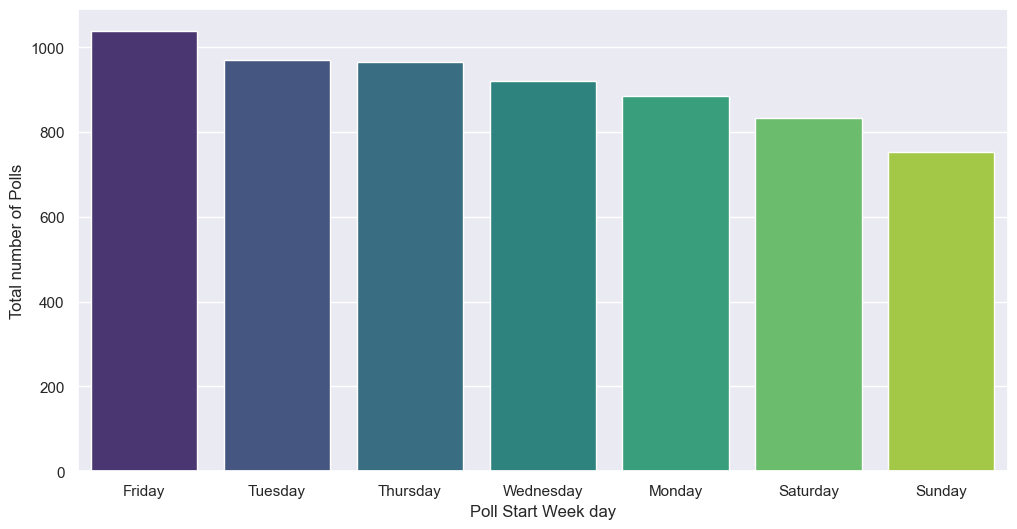

In [54]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_no_outlier_copy,  x='poll_start_weekday', palette='viridis', order=df_no_outlier_copy['poll_start_weekday'].value_counts().index)
plt.xlabel('Poll Start Week day')
plt.ylabel('Total number of Polls')
plt.show()

Observation:

* The number of polls is much higher on Fridays, followed by Tuesdays and Thursdays.

# Bivariate relationship with Target variable (Candidate Name)

In [55]:
def plot_kde_by_candidate_grid(dataframe, x_cols, candidate1, candidate2, colors):
    n_cols = 3
    n_rows = (len(x_cols) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    # Flatten the axs array for easy indexing
    axs = axs.flatten()

    # Iterate over the list of features and plot the KDE of each feature on a separate subplot
    for i, x_col in enumerate(x_cols):
        color1, color2 = colors[i]
        sns.kdeplot(dataframe[dataframe['candidate_name'] == candidate1][x_col], color=color1, shade=True, ax=axs[i])
        sns.kdeplot(dataframe[dataframe['candidate_name'] == candidate2][x_col], color=color2, shade=True, ax=axs[i])

        axs[i].set_xlabel(x_col.capitalize())
        axs[i].set_ylabel('Frequency')

        axs[i].legend([candidate1, candidate2])

    # Remove any unused subplots
    for j in range(len(x_cols), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


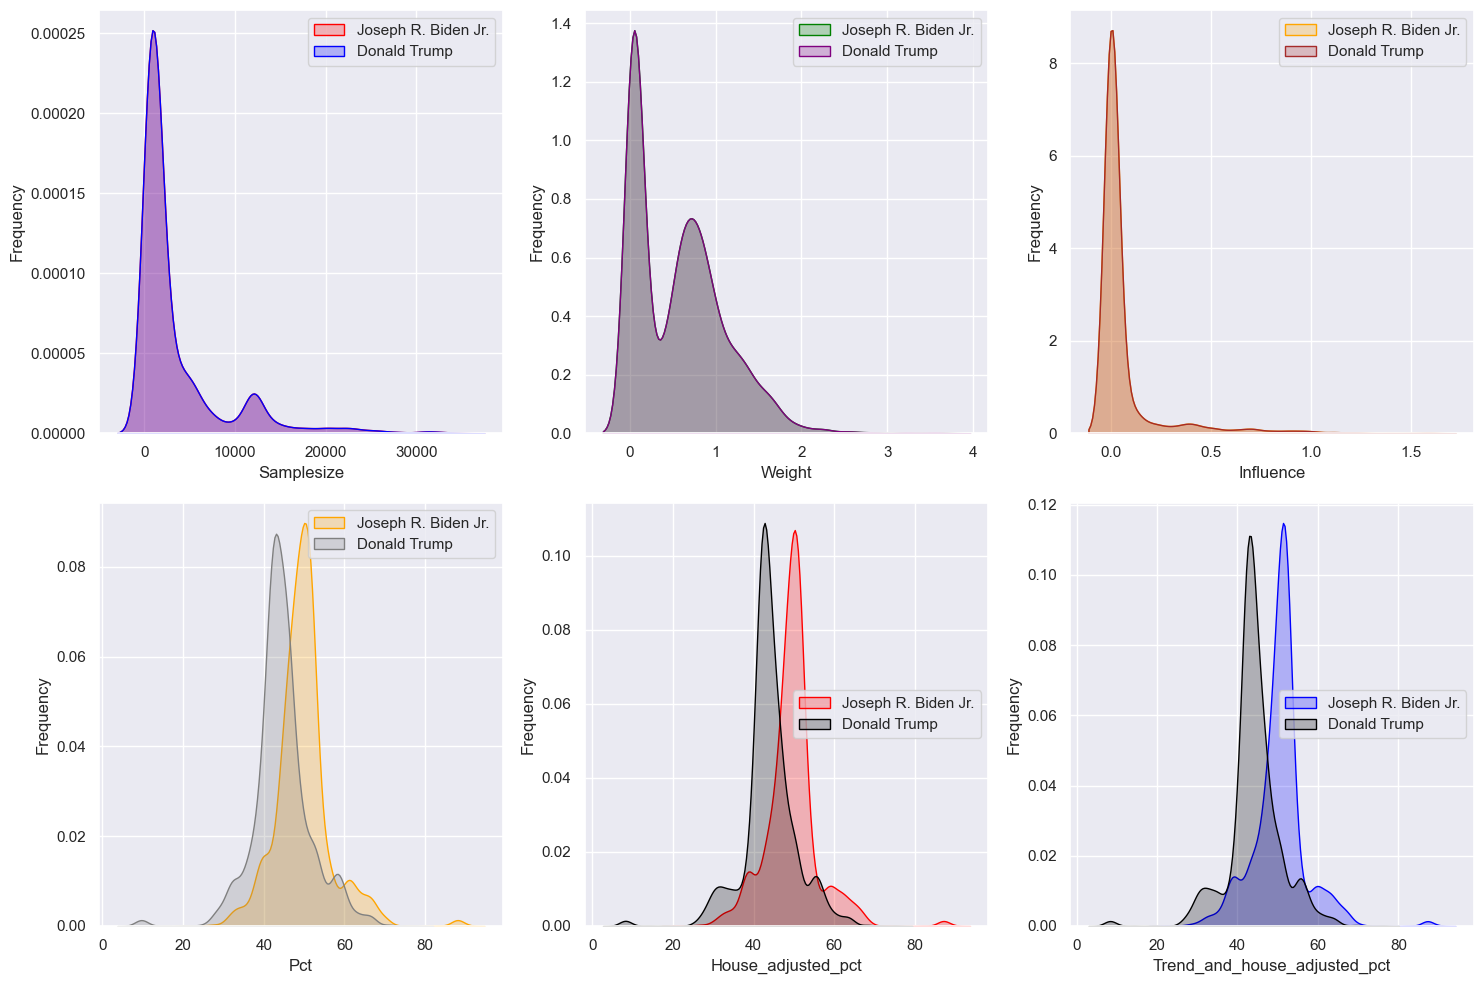

In [56]:
colors = [
    ('red', 'blue'),     
    ('green', 'purple'),
    ('orange', 'brown'),
    ("orange", "gray"),
    ("red", "black"),
    ("blue", "black"),
]

x_cols = ['samplesize', 'weight', 'influence', 'pct', 'house_adjusted_pct', 'trend_and_house_adjusted_pct']
plot_kde_by_candidate_grid(df_no_outlier_copy, x_cols, "Joseph R. Biden Jr.", "Donald Trump", colors)

Observation:

**Samplesize**
* The distribution is heavily right-skewed for both candidates, indicating that most polls have relatively small sample sizes, with a few polls having significantly larger samples. Both candidates have a very similar distribution pattern, showing no significant difference in the sample sizes of the polls conducted for each candidate.

**Weight**
* The weight distributions for both candidates are quite similar, showing a bimodal pattern with peaks around 0.0-0.5 and another around 0.7-1.5. This indicates that the weighting of polls is consistent across both candidates, with most weights falling within these two ranges.

**Influence**
* Both candidates show a high peak at the lower end of the influence score, suggesting that most polls have a low influence score. The distributions are similar, indicating no major differences in how influential the polls are for each candidate.

**Pct**
* Joseph R. Biden Jr. has a peak around the 50% mark, indicating a higher concentration of polls showing him with around 50% support. Donald Trump shows a peak around the 40-45% mark. This suggests that Biden has a higher overall support in the polls compared to Trump.

**House_adjusted_pct**
* Donald Trump has a pronounced peak around the 49-54% mark, while Joseph R. Biden Jr. has a peak around the 57-59% mark. This suggests that after adjusting for house effects, Trump has a higher level of support compared to Biden.

**Trend_and_house_adjusted_pct**
* The distributions show similar peaks to the house-adjusted percentages, with Biden having a peak around 50-55% and Trump around 40-45%. This further confirms that Biden generally has higher adjusted support levels compared to Trump.

Overall Observation
Across most metrics, Biden appears to have slightly higher support and favorable adjustments compared to Trump. The consistency in the distributions between the candidates in terms of sample size, weight, and influence suggests that the polling methodology is similar for both candidates, while the differences in support percentages highlight the varying levels of voter support.

In [57]:
df_no_outlier_copy['poll_duration_pct'] = df_no_outlier_copy['poll_duration'] * df_no_outlier_copy['pct']
df_no_outlier_copy['pollster_influence_weighted_samplesize'] = df_no_outlier_copy['pollster_influence_weighted'] * df_no_outlier_copy['samplesize']

In [58]:
numeric_cols = df_no_outlier_copy.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop(['question_id', 'cycle', 'poll_id'])

In [59]:
categorical_cols = df_no_outlier_copy.select_dtypes(include=['object']).columns
numerical_cols = df_no_outlier_copy.select_dtypes(include=['number']).columns

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: Index(['state', 'candidate_name', 'pollster', 'population', 'tracking',
       'poll_start_weekday', 'time_of_day', 'poll_end_weekday',
       'end_time_of_day'],
      dtype='object')
Numerical Columns: Index(['cycle', 'samplesize', 'weight', 'influence', 'pct',
       'house_adjusted_pct', 'trend_and_house_adjusted_pct', 'poll_id',
       'question_id', 'poll_duration', 'poll_start_year', 'poll_start_month',
       'poll_start_day', 'pollster_influence_weighted',
       'poll_start_weekofyear', 'poll_start_dayofweek', 'poll_start_minute',
       'poll_start_hour', 'poll_end_year', 'poll_end_month', 'poll_end_day',
       'poll_end_weekofyear', 'poll_end_dayofweek', 'poll_end_minute',
       'poll_end_hour', 'model_month', 'model_quarter', 'model_dayofweek',
       'model_to_start_days', 'model_to_end_days', 'poll_duration_pct',
       'pollster_influence_weighted_samplesize'],
      dtype='object')


In [60]:
categorical_cols

Index(['state', 'candidate_name', 'pollster', 'population', 'tracking',
       'poll_start_weekday', 'time_of_day', 'poll_end_weekday',
       'end_time_of_day'],
      dtype='object')

In [61]:
def plot_categorical_barplots(dataframe, categorical_cols, target_col, n_cols=2):
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols 
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))

    axs = axs.flatten()

    for i, col in enumerate(categorical_cols):
        plot_data = dataframe.groupby([col, target_col]).size().reset_index(name='counts')
        sns.barplot(x=col, y='counts', hue=target_col, data=plot_data, ax=axs[i])
        axs[i].set_ylabel('Counts')
        axs[i].set_title(f'{col.capitalize()} vs {target_col.capitalize()}')
        axs[i].tick_params(axis='x', rotation=45)


    for j in range(len(categorical_cols), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

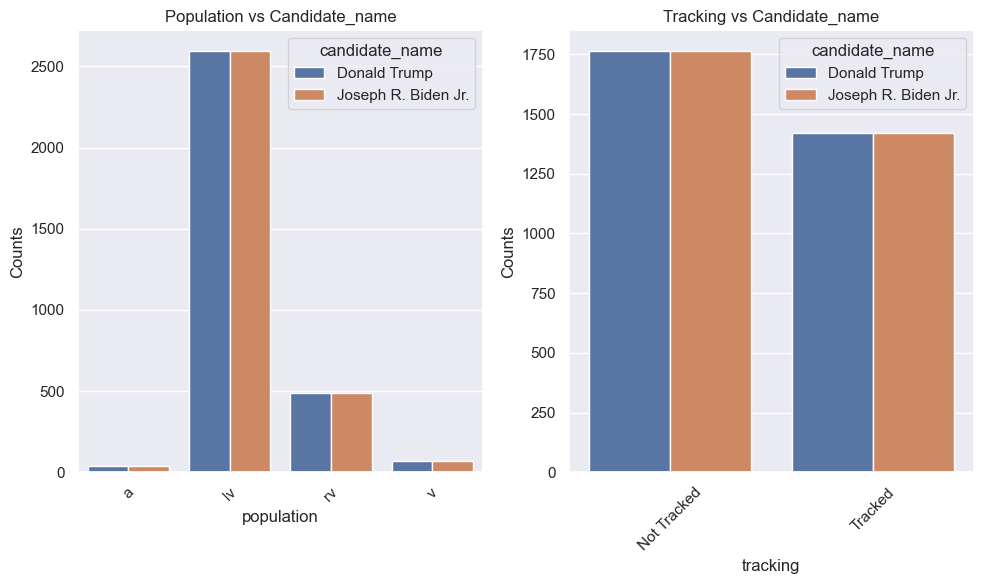

In [62]:
categorical_cols = ['population', 'tracking']
plot_categorical_barplots(df_no_outlier_copy, categorical_cols, 'candidate_name')

Observation:

* Both candidates have the same number of supporters, with both tracked and non-tracked votes distributed equally across the polls.

In [63]:
df_analysis = df_no_outlier_copy

df_analysis['candidate_name'] = df_analysis['candidate_name'].astype('category')
# Group the data by state and candidate, and calculate the proportion of the votes for each candidate in each state
probabilities = df_analysis.groupby(['state', 'candidate_name'])['candidate_name'].count() / df_analysis.groupby('state')['candidate_name'].count()
probabilities = probabilities.unstack().reset_index()
probabilities = probabilities.rename(columns={'state': 'State', 'Trump': 'Trump Probability', 'Biden': 'Biden Probability'})
print(probabilities)

candidate_name                 State  Donald Trump  Joseph R. Biden Jr.
0                            Alabama           0.5                  0.5
1                             Alaska           0.5                  0.5
2                            Arizona           0.5                  0.5
3                           Arkansas           0.5                  0.5
4                         California           0.5                  0.5
5                           Colorado           0.5                  0.5
6                        Connecticut           0.5                  0.5
7                           Delaware           0.5                  0.5
8               District of Columbia           0.5                  0.5
9                            Florida           0.5                  0.5
10                           Georgia           0.5                  0.5
11                            Hawaii           0.5                  0.5
12                             Idaho           0.5              

Observation:

* Both candidates have the same poll across all state

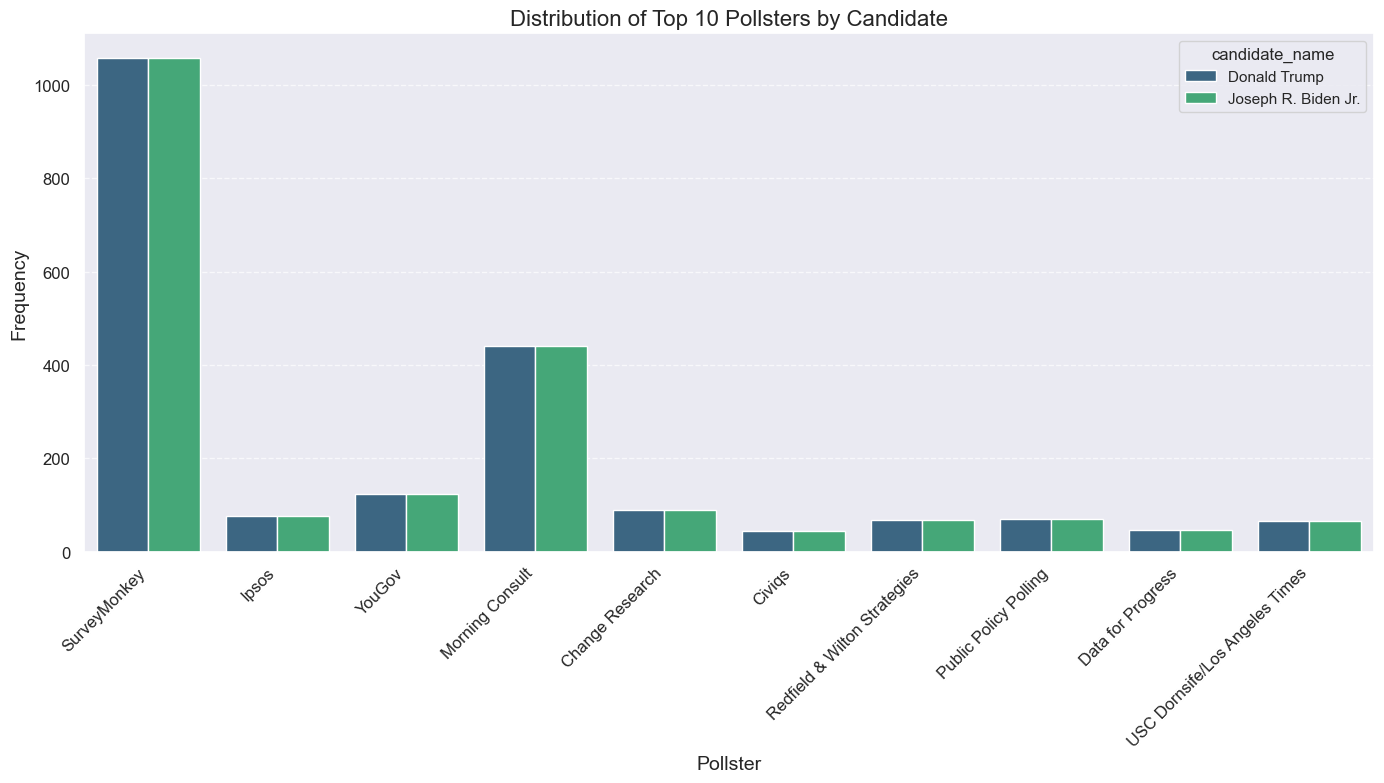

In [64]:
top_10_pollsters = df_no_outlier_copy['pollster'].value_counts().head(10).index
filtered_df = df_no_outlier_copy[df_no_outlier_copy['pollster'].isin(top_10_pollsters)]
plt.figure(figsize=(14, 8))
sns.countplot(x='pollster', hue='candidate_name', data=filtered_df, palette='viridis')
plt.title('Distribution of Top 10 Pollsters by Candidate', fontsize=16)
plt.xlabel('Pollster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Observation:**

* Both candidates have the same number of pollster votes, distributed equally across the polls.

# Encode the Categorical Features

In [65]:
df_no_outlier_copy.drop(
    ['cycle', 'question_id', 'poll_id', 'startdate', 'enddate', 'modeldate', 'poll_start_weekday', 'poll_end_weekday'],
    axis = 1, inplace = True
)

df_clean = df_no_outlier_copy.copy()

In [66]:
print(df_clean.dtypes)

state                                       object
candidate_name                            category
pollster                                    object
samplesize                                 float64
population                                  object
weight                                     float64
influence                                  float64
pct                                        float64
house_adjusted_pct                         float64
trend_and_house_adjusted_pct               float64
tracking                                    object
poll_duration                                int64
poll_start_year                              int32
poll_start_month                             int32
poll_start_day                               int32
pollster_influence_weighted                float64
poll_start_weekofyear                       UInt32
poll_start_dayofweek                         int32
poll_start_minute                            int32
poll_start_hour                

In [67]:
df_clean.head()

,state,candidate_name,pollster,samplesize,population,weight,influence,pct,house_adjusted_pct,trend_and_house_adjusted_pct,tracking,poll_duration,poll_start_year,poll_start_month,poll_start_day,pollster_influence_weighted,poll_start_weekofyear,poll_start_dayofweek,poll_start_minute,poll_start_hour,time_of_day,poll_end_year,poll_end_month,poll_end_day,poll_end_weekofyear,poll_end_dayofweek,poll_end_minute,poll_end_hour,end_time_of_day,model_month,model_quarter,model_dayofweek,model_to_start_days,model_to_end_days,poll_duration_pct,pollster_influence_weighted_samplesize
0,Wyoming,Joseph R. Biden Jr.,SurveyMonkey,654.0,lv,0.355849,0.355849,31.0,29.72329,29.76474,Tracked,27,2020,9,28,0.126629,40,0,0,0,Afternoon,2020,10,25,43,6,0,0,Afternoon,10,4,1,29,2,837.0,82.815279
1,Wyoming,Joseph R. Biden Jr.,SurveyMonkey,649.0,lv,0.024280,0.024138,31.0,29.72329,29.77189,Tracked,28,2020,9,26,0.000586,39,5,0,0,Afternoon,2020,10,24,43,5,0,0,Afternoon,10,4,1,31,3,868.0,0.380355
2,Wyoming,Joseph R. Biden Jr.,SurveyMonkey,638.0,lv,0.000000,0.000000,31.0,29.72329,29.78049,Tracked,27,2020,9,26,0.000000,39,5,0,0,Afternoon,2020,10,23,43,4,0,0,Afternoon,10,4,1,31,4,837.0,0.000000
3,Wyoming,Joseph R. Biden Jr.,SurveyMonkey,616.0,lv,0.011784,0.011371,30.0,28.73825,28.84013,Tracked,27,2020,9,25,0.000134,39,4,0,0,Afternoon,2020,10,22,43,3,0,0,Afternoon,10,4,1,32,5,810.0,0.082542
4,Wyoming,Joseph R. Biden Jr.,SurveyMonkey,605.0,lv,0.011547,0.011076,31.0,29.72329,29.83638,Tracked,27,2020,9,24,0.000128,39,3,0,0,Afternoon,2020,10,21,43,2,0,0,Afternoon,10,4,1,33,6,837.0,0.077375


In [68]:
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns

print("Categorical Columns:", categorical_cols)

Categorical Columns: Index(['state', 'candidate_name', 'pollster', 'population', 'tracking',
       'time_of_day', 'end_time_of_day'],
      dtype='object')


In [69]:
df_clean.state.unique()

array(['Wyoming', 'Wisconsin', 'West Virginia', 'Washington', 'Virginia',
       'Vermont', 'Utah', 'Texas', 'Tennessee', 'South Dakota',
       'South Carolina', 'Rhode Island', 'Pennsylvania', 'Oregon',
       'Oklahoma', 'Ohio', 'North Dakota', 'North Carolina', 'New York',
       'New Mexico', 'New Jersey', 'New Hampshire', 'Nevada', 'Nebraska',
       'National', 'NE-2', 'NE-1', 'Montana', 'Missouri', 'Mississippi',
       'Minnesota', 'Michigan', 'Massachusetts', 'Maryland', 'Maine',
       'ME-2', 'ME-1', 'Louisiana', 'Kentucky', 'Kansas', 'Iowa',
       'Indiana', 'Illinois', 'Idaho', 'Hawaii', 'Georgia', 'Florida',
       'District of Columbia', 'Delaware', 'Connecticut', 'Colorado',
       'California', 'Arkansas', 'Arizona', 'Alaska', 'Alabama'],
      dtype=object)

In [70]:
df_clean.candidate_name.unique()

['Joseph R. Biden Jr.', 'Donald Trump']
Categories (2, object): ['Donald Trump', 'Joseph R. Biden Jr.']

In [71]:
# Convert candidate_name back to object type
df_clean['candidate_name'] = df_clean['candidate_name'].astype(str)

print(df_clean['candidate_name'].unique())

['Joseph R. Biden Jr.' 'Donald Trump']


In [72]:
df_clean.pollster.unique()

array(['SurveyMonkey', 'Ipsos', 'YouGov', 'Gravis Marketing',
       'RMG Research', 'Morning Consult',
       'Fox News/Beacon Research/Shaw & Co. Research',
       'Susquehanna Polling & Research Inc.', 'Latino Decisions',
       'Change Research', 'Trafalgar Group', 'Civiqs',
       'David Binder Research', 'Siena College/The New York Times Upshot',
       'Baldwin Wallace University', 'Redfield & Wilton Strategies',
       'Marquette University Law School', 'Marist College',
       'Garin-Hart-Yang Research Group', 'Ogden & Fry',
       'ABC News/The Washington Post', 'SSRS', 'Emerson College',
       'Benenson Strategy Group/GS Strategy Group',
       'Rasmussen Reports/Pulse Opinion Research', 'Hodas & Associates',
       'Opinium', 'OnMessage Inc.', 'Global Strategy Group',
       'Spry Strategies', 'Public Policy Polling', 'Optimus',
       'Expedition Strategies', 'Quinnipiac University', 'Tarrance Group',
       'Triton Polling & Research', 'Research America Inc.',
       'WP

In [73]:
df_clean.population.unique()

array(['lv', 'rv', 'v', 'a'], dtype=object)

In [74]:
df_clean.tracking.unique()

array(['Tracked', 'Not Tracked'], dtype=object)

In [75]:
df_clean.time_of_day.unique()

array(['Afternoon'], dtype=object)

In [76]:
label_encoder = LabelEncoder()

state_info = df_clean['state']

candidate_map = {'Joseph R. Biden Jr.': 1, 'Donald Trump': 0}
df_clean["candidate_winner"] = df_clean["candidate_name"].map(candidate_map)
df_clean['population_encoded'] = label_encoder.fit_transform(df_clean['population'])
df_clean['tracking_encoded'] = label_encoder.fit_transform(df_clean['tracking'])

# One-hot encode categorical features
df_clean = pd.get_dummies(df_clean, columns=['state', 'pollster'], drop_first=True)

In [77]:
df_clean.drop(
    [
        'candidate_name', 'population', 'tracking', 'time_of_day', 'end_time_of_day', 'poll_start_year', 'poll_end_year', 'poll_start_minute', 
        'poll_end_minute', 'poll_start_hour', 'poll_end_hour', 'poll_end_dayofweek', 'model_to_start_days', 'model_dayofweek', 'model_quarter', 'model_month'
    ],
    axis = 1, inplace = True
)

In [78]:
df_clean.head()

,samplesize,weight,influence,pct,house_adjusted_pct,trend_and_house_adjusted_pct,poll_duration,poll_start_month,poll_start_day,pollster_influence_weighted,poll_start_weekofyear,poll_start_dayofweek,poll_end_month,poll_end_day,poll_end_weekofyear,model_to_end_days,poll_duration_pct,pollster_influence_weighted_samplesize,candidate_winner,population_encoded,tracking_encoded,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District of Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_ME-1,state_ME-2,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_NE-1,state_NE-2,state_National,state_Nebraska,state_Nevada,state_New Hampshire,state_New Jersey,state_New Mexico,state_New York,state_North Carolina,state_North Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Carolina,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,pollster_ALG Research,pollster_AP-NORC,pollster_Abacus Data,pollster_Alaska Survey Research,pollster_Amber Integrated,pollster_American Research Group,pollster_American Viewpoint,pollster_AtlasIntel,pollster_Auburn University at Montgomery,pollster_BK Strategies,pollster_Baldwin Wallace University,pollster_Basswood Research,pollster_Battleground Connect,pollster_Beacon Research,pollster_Benenson Strategy Group/GS Strategy Group,pollster_Bluegrass Voters Coalition,pollster_Braun Research,pollster_CPEC,pollster_Cardinal Point Analytics (CardinalGPS),pollster_Center for Marketing and Opinion Research/University of Akron,pollster_Change Research,pollster_Cherry Communications,pollster_Chism Strategies,pollster_Christopher Newport University,pollster_Civiqs,pollster_Clearview Research,pollster_Climate Nexus,pollster_Colby College,pollster_Cole Hargrave Snodgrass & Associates,pollster_Critical Insights,pollster_Cygnal,pollster_DCCC Targeting and Analytics Department,pollster_DFM Research,pollster_DHM Research,pollster_DKC Analytics,pollster_Data Orbital,pollster_Data for Progress,pollster_David Binder Research,pollster_EKOS Research Associates,pollster_EMC Research,pollster_EPIC-MRA,pollster_East Carolina University,pollster_East Tennessee State University,pollster_Echelon Insights,pollster_Edison Research,pollster_Emerson College,pollster_Expedition Strategies,pollster_FM3 Research,pollster_Fabrizio Ward/Hart Research Associates,"pollster_Fabrizio, Lee & Associates",pollster_Fairleigh Dickinson University (PublicMind),pollster_Florida Atlantic University,pollster_Fox News/Beacon Research/Shaw & Co. Research,pollster_Franklin & Marshall College,pollster_GBAO,pollster_GQR Research (GQRR),pollster_Garin-Hart-Yang Research Group,pollster_Georgetown University (Battleground),pollster_Glengariff Group,pollster_Global Marketing Research Services,pollster_Global Strategy Group,pollster_Global Strategy Group/GBAO/Navigator Research,pollster_Gonzales Research & Marketing Strategies Inc.,pollster_Goucher College,pollster_Gravis Marketing,pollster_HIT Strategies,pollster_Hampton University,pollster_Harper Polling,pollster_Harris Insights & Analytics,pollster_Harstad Strategic Research Inc.,pollster_Hendrix College,pollster_HighGround Inc.,pollster_Hodas & Associates,pollster_Hofstra University,pollster_IBD/TIPP,pollster_Innovative Research Group,pollster_Ipsos,pollster_J.L. Partners,pollster_John Zogby Strategies/EMI Research Solutions,pollster_Kaiser Family Foundation,pollster_Keating Research/OnSight Public Affairs/Melanson,pollster_Kiaer Research,pollster_LOC Wick,pollster_Landmark Communications,pollster_Latino Decisions,pollster_Lord Ashcroft Polls,pollster_Léger,pollster_MRG Research,pollster_MSR Group,pollster_Marist College,pollster_Marketin

# Correlation

In [79]:
def correlated_feature_extraction(dataframe, threshold: int = 0.95):
  
  """ Method that selects features based on the most correlated features with the label classes
  and discard the intercorrelated features.
  """

  highly_correlated_feature_pairs = []
  highly_correlated_features_to_drop = []

  correlation_matrix = dataframe.corr().abs()
  upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
  for row in range(upper_matrix.shape[0]):
      for column in range(upper_matrix.shape[1]):
          if upper_matrix.iloc[row, column] > threshold:
              highly_correlated_feature_pairs.append([row, column, upper_matrix.iloc[row, column]])

  highly_correlated_feature_pairs = pd.DataFrame(highly_correlated_feature_pairs).sort_values(by=[2], ascending=False)
  highly_correlated_feature_pairs.columns = ['feature_1', 'feature_2', 'correlation_coefficient']
  highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > threshold)]
  dataset = dataframe.drop(dataframe[highly_correlated_features_to_drop], axis=1)
  # dataset.drop(['label'], axis=1, inplace=True)

  nr_features = dataset.shape[1] - 1
  print('Total number of features before correlation: ',dataframe.shape[1])
  print(f'Number of highly intercorrelated feature pairs: {len(highly_correlated_feature_pairs)}')
  print(f'Optimized number of features: {nr_features}')
  
  return (highly_correlated_feature_pairs, dataset)

The correlation between each feature and the dependent variable, as well as the correlation among features (intercorrelation), provide elements to tackle potential undesired collinearity.

The code below assists in identifying and sorting high feature intercorrelation cases based on the corresponding correlation coefficients (in descending order). A threshold of 0.95 has been arbitrarily defined for filtering highly intercorrelated features.

In [80]:
highly_correlated_feature_pairs, data_cleaned = correlated_feature_extraction(df_clean)

Total number of features before correlation:  267
Number of highly intercorrelated feature pairs: 10
Optimized number of features: 260


In [81]:
highly_correlated_feature_pairs.head(15)

,feature_1,feature_2,correlation_coefficient
2,4,5,0.994097
4,7,10,0.986811
7,10,12,0.983193
9,12,14,0.981121
0,3,4,0.977746
5,7,12,0.972315
8,10,14,0.970459
1,3,5,0.968745
6,7,14,0.957698
3,6,16,0.953574


For information only, the 10 most intercorrelated feature pairs are identified above along with their corresponding correlation coefficients. This problem must always be addressed in data preprocessing.

After dropping, the number of features was substantially reduced from 269 down to 262. Such dimensionality optimization not only assists in mitigating collinearity but also allows for the creation of streamlined machines and faster learning with lower processing and memory requirements.

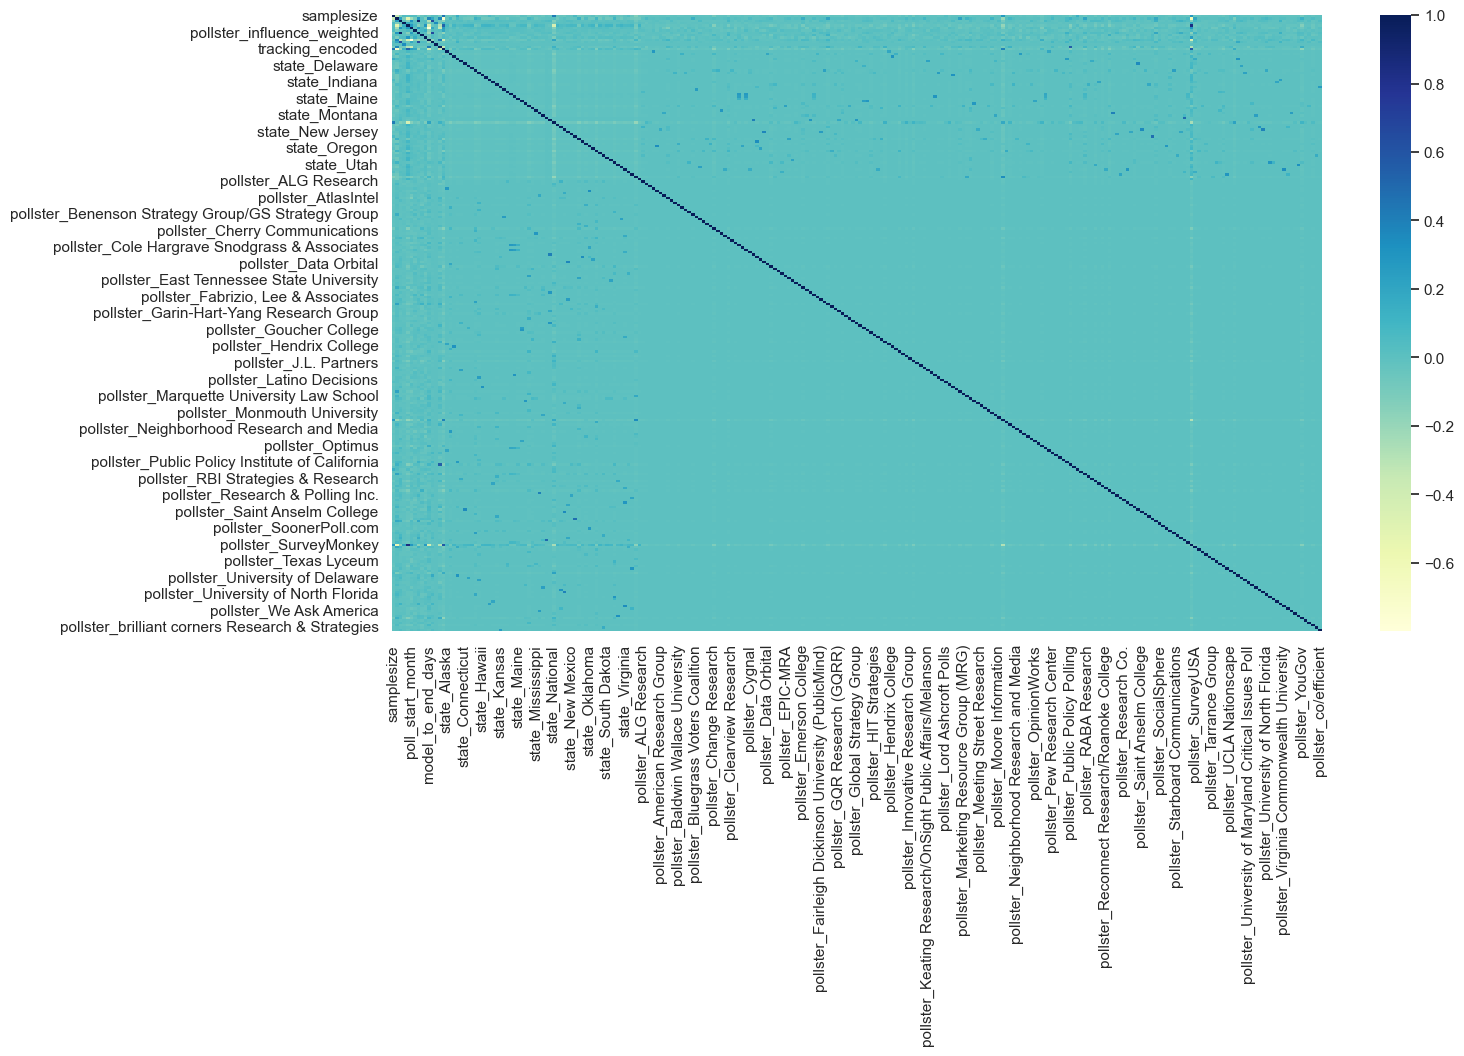

In [82]:
plt.figure(figsize=(15, 8))
corr_matrix = data_cleaned.corr()
sns.heatmap(corr_matrix, cmap="YlGnBu")
plt.show()

In [83]:
corr_matrix.candidate_winner.sort_values(ascending=False)

candidate_winner                                                          1.000000e+00
pct                                                                       3.461593e-01
model_to_end_days                                                         1.089258e-15
state_National                                                            9.788873e-16
poll_start_dayofweek                                                      8.087391e-16
poll_end_day                                                              4.776334e-16
state_Georgia                                                             4.756595e-16
poll_start_day                                                            4.266279e-16
pollster_USC Dornsife/Los Angeles Times                                   4.190661e-16
state_Arizona                                                             4.112461e-16
state_Florida                                                             3.879373e-16
state_Iowa                                 

Interpretation:
* The results indicate that most features have a very weak (near-zero) correlation with candidate_winner, except for pct, which shows a moderate positive correlation. This makes sense because the percentage (pct) is directly related to election results, whereas the other variables like poll_day, poll_month, pollster, etc., should not have a direct impact on the winner in a logical sense.

In [84]:
x = data_cleaned.drop(['candidate_winner'], axis= 1)
y = data_cleaned.candidate_winner

data_prepared = data_cleaned.drop(['candidate_winner'], axis= 1)

# Split and Scale the Data

In [85]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state= 42, test_size= 0.33)

In [86]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4265, 260) (2101, 260) (4265,) (2101,)


In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, StratifiedKFold

In [88]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_scaled= pd.DataFrame(X_train_scaled, columns= x.columns)
X_train_scaled.head()

,samplesize,weight,influence,pct,poll_duration,poll_start_month,poll_start_day,pollster_influence_weighted,poll_start_dayofweek,poll_end_day,model_to_end_days,pollster_influence_weighted_samplesize,population_encoded,tracking_encoded,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District of Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_ME-1,state_ME-2,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_NE-1,state_NE-2,state_National,state_Nebraska,state_Nevada,state_New Hampshire,state_New Jersey,state_New Mexico,state_New York,state_North Carolina,state_North Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Carolina,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,pollster_ALG Research,pollster_AP-NORC,pollster_Abacus Data,pollster_Alaska Survey Research,pollster_Amber Integrated,pollster_American Research Group,pollster_American Viewpoint,pollster_AtlasIntel,pollster_Auburn University at Montgomery,pollster_BK Strategies,pollster_Baldwin Wallace University,pollster_Basswood Research,pollster_Battleground Connect,pollster_Beacon Research,pollster_Benenson Strategy Group/GS Strategy Group,pollster_Bluegrass Voters Coalition,pollster_Braun Research,pollster_CPEC,pollster_Cardinal Point Analytics (CardinalGPS),pollster_Center for Marketing and Opinion Research/University of Akron,pollster_Change Research,pollster_Cherry Communications,pollster_Chism Strategies,pollster_Christopher Newport University,pollster_Civiqs,pollster_Clearview Research,pollster_Climate Nexus,pollster_Colby College,pollster_Cole Hargrave Snodgrass & Associates,pollster_Critical Insights,pollster_Cygnal,pollster_DCCC Targeting and Analytics Department,pollster_DFM Research,pollster_DHM Research,pollster_DKC Analytics,pollster_Data Orbital,pollster_Data for Progress,pollster_David Binder Research,pollster_EKOS Research Associates,pollster_EMC Research,pollster_EPIC-MRA,pollster_East Carolina University,pollster_East Tennessee State University,pollster_Echelon Insights,pollster_Edison Research,pollster_Emerson College,pollster_Expedition Strategies,pollster_FM3 Research,pollster_Fabrizio Ward/Hart Research Associates,"pollster_Fabrizio, Lee & Associates",pollster_Fairleigh Dickinson University (PublicMind),pollster_Florida Atlantic University,pollster_Fox News/Beacon Research/Shaw & Co. Research,pollster_Franklin & Marshall College,pollster_GBAO,pollster_GQR Research (GQRR),pollster_Garin-Hart-Yang Research Group,pollster_Georgetown University (Battleground),pollster_Glengariff Group,pollster_Global Marketing Research Services,pollster_Global Strategy Group,pollster_Global Strategy Group/GBAO/Navigator Research,pollster_Gonzales Research & Marketing Strategies Inc.,pollster_Goucher College,pollster_Gravis Marketing,pollster_HIT Strategies,pollster_Hampton University,pollster_Harper Polling,pollster_Harris Insights & Analytics,pollster_Harstad Strategic Research Inc.,pollster_Hendrix College,pollster_HighGround Inc.,pollster_Hodas & Associates,pollster_Hofstra University,pollster_IBD/TIPP,pollster_Innovative Research Group,pollster_Ipsos,pollster_J.L. Partners,pollster_John Zogby Strategies/EMI Research Solutions,pollster_Kaiser Family Foundation,pollster_Keating Research/OnSight Public Affairs/Melanson,pollster_Kiaer Research,pollster_LOC Wick,pollster_Landmark Communications,pollster_Latino Decisions,pollster_Lord Ashcroft Polls,pollster_Léger,pollster_MRG Research,pollster_MSR Group,pollster_Marist College,pollster_Marketing Resource Group (MRG),pollster_Marquette University Law School,pollster_Mason-Dixon Polling & Strategy,pollster_MassINC Polling Group,polls

# Model Building and Evaluation Metrics

Since this is a Binary Classification problem, we can use the 2 following popular metrics.

1. Area under the Receiver Operating Characteristic Curve
2. ROC AUC

Understanding Metrics
* Recall: This measures the proportion of actual positives that are correctly identified. In this context, a high recall indicates that most of the actual winning candidates are correctly predicted the model.
* ROC AUC: This provides an aggregate measure of performance across all classification thresholds. The AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. A higher AUC indicates a better performing model.

* Why recall and ROC AUC are important metrics for your binary classification problem
- In the context of predicting the correct candidate winner in an election

Using Recall and ROC AUC
* Recall is particularly useful when you care more about false negatives (e.g., missing an actual winner) than false positives.
* ROC AUC helps you understand the overall ability of the model to distinguish between the two classes across different thresholds.

In [89]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
prob_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred = log_reg.predict(X_test_scaled)

ROC AUC score of Logistic Regression: 0.6932
Recall score of Logistic Regression: 0.6906


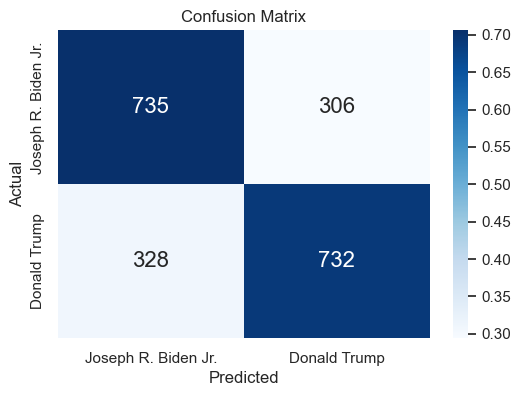

In [90]:
def confusion_matrix_plot(y_test, y_pred, candidate_map, normalized=True, cmap='Blues'):
    """Function to visualize how well the model performed on the test set."""

    cat = candidate_map.keys()
    # Set the tick labels for the x and y axes
    xticklabels = list(cat)
    yticklabels = list(cat)

    cm = confusion_matrix(y_test, y_pred)
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(norm_cm, annot=cm, fmt='d', cmap=cmap,
                xticklabels=xticklabels,
                yticklabels=yticklabels,
                annot_kws={"size": 16})
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

print(f"ROC AUC score of Logistic Regression: {roc_auc_score(y_test, prob_pred):.4f}")
print(f"Recall score of Logistic Regression: {recall_score(y_test, y_pred):.4f}")

confusion_matrix_plot(y_test, y_pred, candidate_map)

# Model Analysis

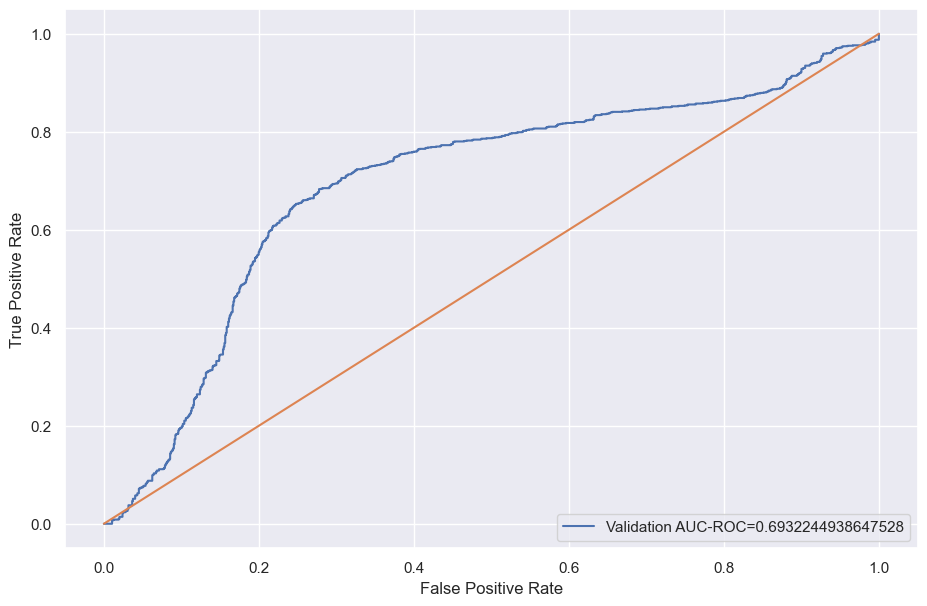

In [91]:
plt.figure(figsize = (11, 7))
fpr, tpr, _ = roc_curve(y_test, prob_pred)
auc = roc_auc_score(y_test, prob_pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

# Model Evaluation using Cross Validation

In [92]:
from typing import List

In [93]:
def cross_validation_score(ml_model, classifier_name, dataframe, cols: List[str], y, thres=0.5, random_st=42, k=5, apply_pca=False, n_components=None):
    """
    Function to calculate the k-fold cross-validation stratified on the basis of the target
    and prints the ROC, Recall, and Precision Scores.
    
    Args:
        ml_model (sklearn estimator): Machine learning model for predictions
        dataframe (pandas DataFrame): DataFrame containing features
        cols (List[str]): List of column names to be used as features
        y (pandas Series): Target variable
        thres (float): Threshold for the probabilities of the model predictions
        random_st (int): Random state for StratifiedKFold
        k (int): Number of folds for cross-validation
        apply_pca (bool): Whether to apply PCA on the features
        n_components (int): Number of PCA components if apply_pca is True
    
    Returns:
        cv_scores (List[float]): Cross-validation scores (ROC AUC)
    """
    
    i = 1
    x1 = dataframe[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_st)
    
    for train_idx, test_idx in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        
        # Split the data
        xtr, xval = x1.iloc[train_idx], x1.iloc[test_idx]
        ytr, yval = y.iloc[train_idx], y.iloc[test_idx]
        
        # Scale the data
        scaler = StandardScaler().fit(xtr)
        xtr_scaled = scaler.transform(xtr)
        xval_scaled = scaler.transform(xval)
        
        # Apply PCA if specified
        if apply_pca:
            if n_components is None:
                raise ValueError("n_components must be specified when apply_pca is True")
            pca = PCA(n_components=n_components, random_state=random_st)
            xtr_scaled = pca.fit_transform(xtr_scaled)
            xval_scaled = pca.transform(xval_scaled)
        
        # Instantiate and fit the model
        model = ml_model.__class__()  # Ensure a fresh model instance
        model.fit(xtr_scaled, ytr)
        pred_probs = model.predict_proba(xval_scaled)
        pp = (pred_probs[:, 1] > thres).astype(int)
        
        # Calculate scores for each fold
        roc_score = roc_auc_score(yval, pred_probs[:, 1])
        recall = recall_score(yval, pp)
        precision = precision_score(yval, pp)
        msg = f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(msg)
        cv_scores.append(roc_score)
        i += 1

        # Log parameters and metrics with mlflow
        with mlflow.start_run(experiment_id=experiment_id, run_name=f"tuning-{classifier_name}", nested=True):
            mlflow.log_params(
                {
                    "threshold": thres,
                    "apply_pca": apply_pca
                }
            )
            if apply_pca:
                mlflow.log_param("n_components", n_components)
            mlflow.log_metrics(
                {
                    "roc_auc": roc_score,
                    "recall": recall,
                    "precision": precision
                }
            )
        
    return cv_scores

In [94]:
# Perform cross-validation on the PCA-transformed features
n_pca_components = 200

# Logistic Regression

In [95]:
log_reg_cv_full = cross_validation_score(LogisticRegression(), 'log_reg_full', data_prepared, cols=data_prepared.columns, y=y, k=10)


1 of KFold 10


ROC AUC Score: 0.7105, Recall Score: 0.7179, Precision Score: 0.7068

2 of KFold 10
ROC AUC Score: 0.6610, Recall Score: 0.6834, Precision Score: 0.6791

3 of KFold 10
ROC AUC Score: 0.6917, Recall Score: 0.7022, Precision Score: 0.7066

4 of KFold 10
ROC AUC Score: 0.6705, Recall Score: 0.6384, Precision Score: 0.6812

5 of KFold 10
ROC AUC Score: 0.6639, Recall Score: 0.6824, Precision Score: 0.6845

6 of KFold 10
ROC AUC Score: 0.6793, Recall Score: 0.6855, Precision Score: 0.7032

7 of KFold 10
ROC AUC Score: 0.6975, Recall Score: 0.7075, Precision Score: 0.7009

8 of KFold 10
ROC AUC Score: 0.6847, Recall Score: 0.7233, Precision Score: 0.6907

9 of KFold 10
ROC AUC Score: 0.6537, Recall Score: 0.6950, Precision Score: 0.6821

10 of KFold 10
ROC AUC Score: 0.6932, Recall Score: 0.6824, Precision Score: 0.7209


![Example Image](ex1.png)

In [96]:
log_reg_cv_pca = cross_validation_score(LogisticRegression(), 'log_reg_pca', data_prepared, cols=data_prepared.columns, y=y, k=10, apply_pca=True, n_components=n_pca_components)


1 of KFold 10


ROC AUC Score: 0.6776, Recall Score: 0.6708, Precision Score: 0.6564

2 of KFold 10
ROC AUC Score: 0.6668, Recall Score: 0.6865, Precision Score: 0.6718

3 of KFold 10
ROC AUC Score: 0.6349, Recall Score: 0.6176, Precision Score: 0.5970

4 of KFold 10
ROC AUC Score: 0.6143, Recall Score: 0.5629, Precision Score: 0.6068

5 of KFold 10
ROC AUC Score: 0.6313, Recall Score: 0.6509, Precision Score: 0.6369

6 of KFold 10
ROC AUC Score: 0.6724, Recall Score: 0.6730, Precision Score: 0.6794

7 of KFold 10
ROC AUC Score: 0.6281, Recall Score: 0.6195, Precision Score: 0.6137

8 of KFold 10
ROC AUC Score: 0.6120, Recall Score: 0.6792, Precision Score: 0.6067

9 of KFold 10
ROC AUC Score: 0.6550, Recall Score: 0.6918, Precision Score: 0.6811

10 of KFold 10
ROC AUC Score: 0.6417, Recall Score: 0.6289, Precision Score: 0.6349


![Example Image](ex2.png)

Notice that recall score, roc auc score decreases while the precision increased a bit down the fold.

# RandomForestClassifier

In [97]:
randF_cv_full = cross_validation_score(RandomForestClassifier(), 'random_forest_full', data_prepared, cols=data_prepared.columns, y=y, k=10)


1 of KFold 10
ROC AUC Score: 0.8544, Recall Score: 0.7555, Precision Score: 0.7651

2 of KFold 10
ROC AUC Score: 0.8444, Recall Score: 0.7712, Precision Score: 0.7477

3 of KFold 10
ROC AUC Score: 0.8752, Recall Score: 0.8150, Precision Score: 0.7927

4 of KFold 10
ROC AUC Score: 0.8313, Recall Score: 0.6950, Precision Score: 0.7893

5 of KFold 10
ROC AUC Score: 0.8378, Recall Score: 0.7547, Precision Score: 0.7619

6 of KFold 10
ROC AUC Score: 0.8628, Recall Score: 0.7767, Precision Score: 0.7792

7 of KFold 10
ROC AUC Score: 0.8431, Recall Score: 0.7358, Precision Score: 0.7932

8 of KFold 10
ROC AUC Score: 0.8483, Recall Score: 0.7799, Precision Score: 0.7654

9 of KFold 10
ROC AUC Score: 0.8324, Recall Score: 0.7579, Precision Score: 0.7603

10 of KFold 10
ROC AUC Score: 0.8470, Recall Score: 0.7516, Precision Score: 0.7735


![Example Image](ex3.png)

The roc auc, recall decreases while precision score slightly improved

In [98]:
randF_cv_pca = cross_validation_score(RandomForestClassifier(), 'random_forest_pca', data_prepared, cols=data_prepared.columns, y=y, k=10, apply_pca=True, n_components=n_pca_components)


1 of KFold 10
ROC AUC Score: 0.8468, Recall Score: 0.7367, Precision Score: 0.7253

2 of KFold 10
ROC AUC Score: 0.8532, Recall Score: 0.7555, Precision Score: 0.7393

3 of KFold 10
ROC AUC Score: 0.8453, Recall Score: 0.7210, Precision Score: 0.7302

4 of KFold 10
ROC AUC Score: 0.8609, Recall Score: 0.7013, Precision Score: 0.7611

5 of KFold 10
ROC AUC Score: 0.8276, Recall Score: 0.7201, Precision Score: 0.7224

6 of KFold 10
ROC AUC Score: 0.8740, Recall Score: 0.7642, Precision Score: 0.7864

7 of KFold 10
ROC AUC Score: 0.8859, Recall Score: 0.7862, Precision Score: 0.7669

8 of KFold 10
ROC AUC Score: 0.8423, Recall Score: 0.7390, Precision Score: 0.7344

9 of KFold 10
ROC AUC Score: 0.8811, Recall Score: 0.7893, Precision Score: 0.7844

10 of KFold 10
ROC AUC Score: 0.8370, Recall Score: 0.7358, Precision Score: 0.7267


![Example Image](ex4.png)

# GradientBoostingClassifier

In [99]:
grad_boost_full = cross_validation_score(GradientBoostingClassifier(), 'grad_boost_full', data_prepared, cols=data_prepared.columns, y=y, k=10)


1 of KFold 10
ROC AUC Score: 0.9193, Recall Score: 0.8245, Precision Score: 0.8429

2 of KFold 10
ROC AUC Score: 0.9165, Recall Score: 0.8495, Precision Score: 0.8187

3 of KFold 10
ROC AUC Score: 0.9252, Recall Score: 0.8683, Precision Score: 0.8369

4 of KFold 10
ROC AUC Score: 0.8884, Recall Score: 0.7893, Precision Score: 0.8071

5 of KFold 10
ROC AUC Score: 0.9069, Recall Score: 0.8302, Precision Score: 0.8250

6 of KFold 10
ROC AUC Score: 0.9185, Recall Score: 0.8396, Precision Score: 0.8042

7 of KFold 10
ROC AUC Score: 0.9079, Recall Score: 0.8270, Precision Score: 0.8018

8 of KFold 10
ROC AUC Score: 0.9049, Recall Score: 0.8459, Precision Score: 0.8201

9 of KFold 10
ROC AUC Score: 0.9167, Recall Score: 0.8648, Precision Score: 0.8112

10 of KFold 10
ROC AUC Score: 0.9136, Recall Score: 0.7893, Precision Score: 0.8257


![Example Image](ex5.png)

In [100]:
grad_boost_cv_pca = cross_validation_score(GradientBoostingClassifier(), 'grad_boost_pca', data_prepared, cols=data_prepared.columns, y=y, k=10, apply_pca=True, n_components=n_pca_components)


1 of KFold 10
ROC AUC Score: 0.8825, Recall Score: 0.7680, Precision Score: 0.7903

2 of KFold 10
ROC AUC Score: 0.8860, Recall Score: 0.8119, Precision Score: 0.7825

3 of KFold 10
ROC AUC Score: 0.8693, Recall Score: 0.7618, Precision Score: 0.7839

4 of KFold 10
ROC AUC Score: 0.8385, Recall Score: 0.6698, Precision Score: 0.7662

5 of KFold 10
ROC AUC Score: 0.8521, Recall Score: 0.7610, Precision Score: 0.7732

6 of KFold 10
ROC AUC Score: 0.8807, Recall Score: 0.7987, Precision Score: 0.7937

7 of KFold 10
ROC AUC Score: 0.8771, Recall Score: 0.7642, Precision Score: 0.8046

8 of KFold 10
ROC AUC Score: 0.8368, Recall Score: 0.7358, Precision Score: 0.7290

9 of KFold 10
ROC AUC Score: 0.8879, Recall Score: 0.7987, Precision Score: 0.8063

10 of KFold 10
ROC AUC Score: 0.8433, Recall Score: 0.7358, Precision Score: 0.7723


![Example Image](ex6.png)

# DecisionTreeClassifier

In [101]:
dec_tree_cv = cross_validation_score(DecisionTreeClassifier(), 'decision_tree_full', data_prepared, cols=data_prepared.columns, y=y, k=10)


1 of KFold 10
ROC AUC Score: 0.8546, Recall Score: 0.8495, Precision Score: 0.8522

2 of KFold 10
ROC AUC Score: 0.8420, Recall Score: 0.8589, Precision Score: 0.8278

3 of KFold 10
ROC AUC Score: 0.8594, Recall Score: 0.8934, Precision Score: 0.8382

4 of KFold 10
ROC AUC Score: 0.8468, Recall Score: 0.7956, Precision Score: 0.8785

5 of KFold 10
ROC AUC Score: 0.8331, Recall Score: 0.8491, Precision Score: 0.8232

6 of KFold 10
ROC AUC Score: 0.8656, Recall Score: 0.8428, Precision Score: 0.8816

7 of KFold 10
ROC AUC Score: 0.8580, Recall Score: 0.8365, Precision Score: 0.8721

8 of KFold 10
ROC AUC Score: 0.8517, Recall Score: 0.8553, Precision Score: 0.8474

9 of KFold 10
ROC AUC Score: 0.8667, Recall Score: 0.8742, Precision Score: 0.8607

10 of KFold 10
ROC AUC Score: 0.8418, Recall Score: 0.8365, Precision Score: 0.8444


![Example Image](ex7.png)

The precision improved slightly

In [102]:
dec_tree_cv_pca = cross_validation_score(DecisionTreeClassifier(), 'decision_tree_pca', data_prepared, cols=data_prepared.columns, y=y, k=10, apply_pca=True, n_components=n_pca_components)


1 of KFold 10
ROC AUC Score: 0.7334, Recall Score: 0.7304, Precision Score: 0.7327

2 of KFold 10
ROC AUC Score: 0.7040, Recall Score: 0.7398, Precision Score: 0.6880

3 of KFold 10
ROC AUC Score: 0.7400, Recall Score: 0.7618, Precision Score: 0.7275

4 of KFold 10
ROC AUC Score: 0.7280, Recall Score: 0.6887, Precision Score: 0.7449

5 of KFold 10
ROC AUC Score: 0.7575, Recall Score: 0.7421, Precision Score: 0.7613

6 of KFold 10
ROC AUC Score: 0.7781, Recall Score: 0.7925, Precision Score: 0.7660

7 of KFold 10
ROC AUC Score: 0.7709, Recall Score: 0.7642, Precision Score: 0.7739

8 of KFold 10
ROC AUC Score: 0.7448, Recall Score: 0.7327, Precision Score: 0.7492

9 of KFold 10
ROC AUC Score: 0.7964, Recall Score: 0.7767, Precision Score: 0.8072

10 of KFold 10
ROC AUC Score: 0.7349, Recall Score: 0.7107, Precision Score: 0.7434


![Example Image](ex8.png)

Text(0, 0.5, 'ROC Score')

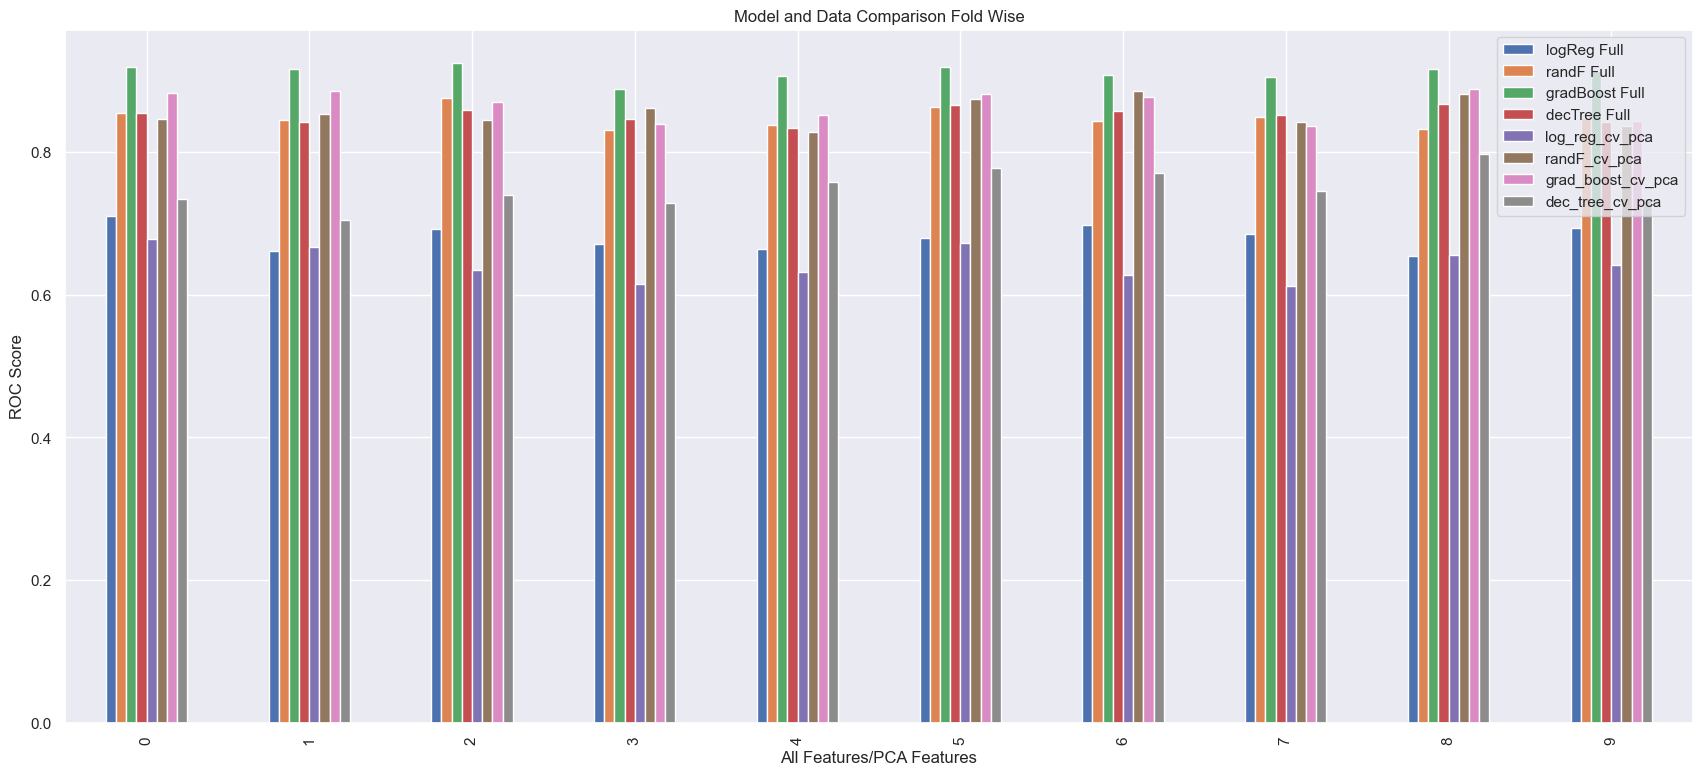

In [103]:
#linear regression, ridge, lasso, elasticnet, dtreg, rfreg
compare_score = pd.DataFrame({
    'logReg Full':log_reg_cv_full,
    'randF Full':randF_cv_full,
    'gradBoost Full':grad_boost_full,
    'decTree Full':dec_tree_cv,
    'log_reg_cv_pca':log_reg_cv_pca,
    'randF_cv_pca':randF_cv_pca,
    'grad_boost_cv_pca':grad_boost_cv_pca,
    'dec_tree_cv_pca':dec_tree_cv_pca
}) 


compare_score.plot(y = ['logReg Full', 'randF Full', 'gradBoost Full', 'decTree Full', 'log_reg_cv_pca', 'randF_cv_pca', 'grad_boost_cv_pca', 'dec_tree_cv_pca'], 
                   kind = 'bar')

plt.title('Model and Data Comparison Fold Wise')
plt.xlabel('All Features/PCA Features')
plt.ylabel('ROC Score')

From the visualization above, it can be seen that Gradient Boost Classifier on all features perfrom better than the rest across the validation.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(data_prepared, y, random_state = 42, stratify = y, 
                                                    test_size=0.33)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [112]:
def state_level_prediction(X_test, state_info, y_test, y_pred):
    X_test.reset_index(drop=True, inplace=True)
    state_info.reset_index(drop=True, inplace=True)
    
    candidate_map = {1: 'Biden', 0: 'Trump'}

    X_test['state'] = state_info.iloc[X_test.index]
    # For state-level prediction
    state_results = X_test[['state']].copy()
    state_results['actual_winner'] = y_test
    state_results['predicted_winner'] = y_pred

    # Aggregate results by state
    state_summary = state_results.groupby('state').agg(
        actual_winner=pd.NamedAgg(column='actual_winner', aggfunc=lambda x: 1 if x.sum() > len(x) / 2 else 0),
        predicted_winner=pd.NamedAgg(column='predicted_winner', aggfunc=lambda x: 1 if x.sum() > len(x) / 2 else 0)
    )
    state_summary["actual_winner"] = state_summary["actual_winner"].map(candidate_map)
    state_summary["predicted_winner"] = state_summary["predicted_winner"].map(candidate_map)

    return state_summary

In [116]:
mlflow.end_run()

ROC AUC score of Gradient Boosting Regression: 0.9068
Recall score of Gradient Boosting Regression: 0.8390
Precision score of Gradient Boosting Regression: 0.8390
Percent misclassified: 18.7530%
Overall Accuracy: 0.8124702522608281
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1051
           1       0.80      0.84      0.82      1050

    accuracy                           0.81      2101
   macro avg       0.81      0.81      0.81      2101
weighted avg       0.81      0.81      0.81      2101



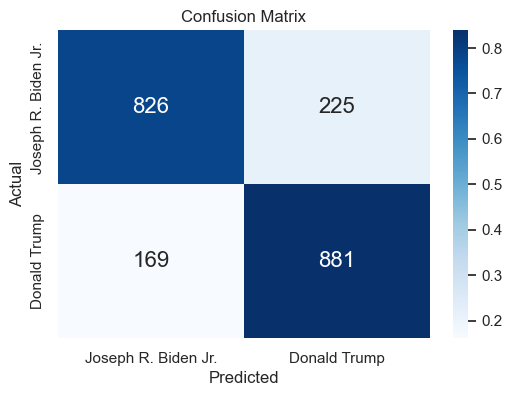

State level prediction summary:

               actual_winner predicted_winner  correct
state                                                 
Montana                Trump            Trump     True
NE-1                   Biden            Biden     True
NE-2                   Trump            Trump     True
National               Trump            Biden    False
Nebraska               Trump            Biden    False
Nevada                 Trump            Biden    False
New Hampshire          Trump            Biden    False
New Jersey             Trump            Trump     True
New Mexico             Trump            Biden    False
New York               Trump            Biden    False
North Carolina         Trump            Trump     True
North Dakota           Trump            Biden    False
Ohio                   Trump            Biden    False
Oklahoma               Trump            Trump     True
Oregon                 Trump            Biden    False
Pennsylvania           Trump    

In [117]:
model = GradientBoostingClassifier()
model.fit(X_train_scaled, y_train)

prob_pred = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

auc= roc_auc_score(y_test, prob_pred)
recall= recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
miss_class_per= np.mean(y_pred != y_test) * 100
acc= accuracy_score(y_test, y_pred)

with mlflow.start_run(experiment_id=experiment_id, run_name=f"tuning-gradient_boost-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S')}"):
    mlflow.log_metrics(
        {
            "roc_auc": auc,
            "recall": recall,
            "precision": precision,
            "percent-missclassified-class":miss_class_per,
            "accuracy":acc
        }
    )

print(f"ROC AUC score of Gradient Boosting Regression: {auc:.4f}")
print(f"Recall score of Gradient Boosting Regression: {recall:.4f}")
print(f"Precision score of Gradient Boosting Regression: {recall:.4f}")
print(f"Percent misclassified: {miss_class_per:.4f}%")
print("Overall Accuracy:",acc)
print(classification_report(y_test, y_pred))

confusion_matrix_plot(y_test, y_pred, candidate_map)

state_summary = state_level_prediction(X_test, state_info, y_test, y_pred)
# Compare state-level outcomes
state_summary['correct'] = state_summary['actual_winner'] == state_summary['predicted_winner']

print("State level prediction summary:\n")
print(state_summary)

if not state_summary['correct'].all():
    print("There are discrepancies at the state level.")
else:
    print("All state level predictions are correct.")

![Example Image](ex9.png)

# Gradient Boost Hyperparameter Tuning

In [118]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the model
gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

In [120]:
prob_pred = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred = best_model.predict(X_test_scaled)

auc= roc_auc_score(y_test, prob_pred)
recall= recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
miss_class_per= np.mean(y_pred != y_test) * 100
acc= accuracy_score(y_test, y_pred)

with mlflow.start_run(experiment_id=experiment_id, run_name=f"tuning-gradient_boost_grid_search-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S')}", nested=True):
    mlflow.log_metrics(
        {
            "roc_auc": auc,
            "recall": recall,
            "precision": precision,
            "percent-missclassified-class":miss_class_per,
            "accuracy":acc
        }
    )

ROC AUC score of Gradient Boosting Regression: 0.9373
Best Recall score of Gradient Boosting Regression: 0.8714
Best Precision score of Gradient Boosting Regression: 0.8714
Best Percent misclassified: 13.7078%
Overall Accuracy: 0.8629224178962399
Best parameters found by GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}


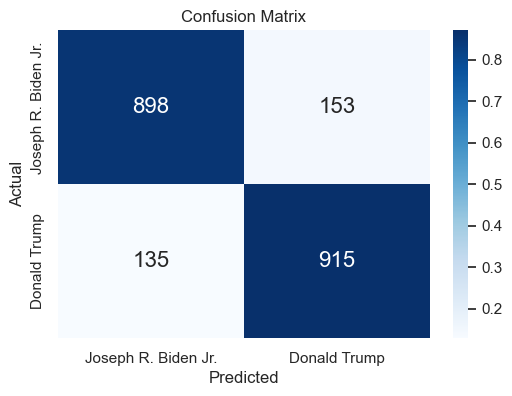

State level prediction summary:

               actual_winner predicted_winner  correct
state                                                 
Montana                Trump            Trump     True
NE-1                   Biden            Biden     True
NE-2                   Trump            Trump     True
National               Trump            Biden    False
Nebraska               Trump            Biden    False
Nevada                 Trump            Biden    False
New Hampshire          Trump            Biden    False
New Jersey             Trump            Trump     True
New Mexico             Trump            Biden    False
New York               Trump            Biden    False
North Carolina         Trump            Trump     True
North Dakota           Trump            Biden    False
Ohio                   Trump            Biden    False
Oklahoma               Trump            Biden    False
Oregon                 Trump            Biden    False
Pennsylvania           Trump    

In [121]:
print(f"ROC AUC score of Gradient Boosting Classifier: {auc:.4f}")
print(f"Best Recall score of Gradient Boosting Classifier: {recall:.4f}")
print(f"Best Precision score of Gradient Boosting Classifier: {recall:.4f}")
print(f"Best Percent misclassified: {miss_class_per:.4f}%")
print("Overall Accuracy:",acc)

print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

confusion_matrix_plot(y_test, y_pred, candidate_map)

state_summary = state_level_prediction(X_test, state_info, y_test, y_pred)
# Compare state-level outcomes
state_summary['correct'] = state_summary['actual_winner'] == state_summary['predicted_winner']

print("State level prediction summary:\n")
print(state_summary)

if not state_summary['correct'].all():
    print("There are discrepancies at the state level.")
else:
    print("All state level predictions are correct.")

![Example Image](ex10.png)

![Example Image](ex11.png)

Comparing both recall and roc auc score we got earlier, this model is far more better. Therefore, we will make use of the this model.